In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import random
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRFRegressor
import unicodedata
import warnings
warnings.simplefilter('ignore')

In [2]:
def show_image(val):
    return '<a href="{}"><img src="{}" width=200></img></a>'.format(val, val)

In [3]:
df = pd.read_csv('competitors_data.csv')
df = df.drop_duplicates()
df = df.dropna(subset=['caracteristics', 'price'])
df['cat_2'] = df['cat_2'].apply(lambda x: str(x).strip())
df['cat_2'] = df['cat_2'].apply(lambda x: x if len(x) > 1 else '')
df['cat_1'] = df['cat_1'].apply(lambda x: x if len(x) > 1 else '')
df['cat_1'] = df['cat_1'].apply(lambda x: str(x).replace('ZonaSporta', '').replace('арт', '').replace('Читать обзор на товар', '').strip())
df['caracteristics'] = df['caracteristics'].apply(lambda x: str(x).replace(':: ', ': ').replace('\xa0', ''))
df['caracteristics'] = df['caracteristics'].apply(lambda x: unicodedata.normalize('NFKD', x))
df = df.reset_index(drop=True)
df.iloc[2000:2001].style.format({'url': show_image, **{'width': '200px'}})

,title,article,price,cat_1,cat_2,cat_3,description,caracteristics,source,date,url
2000,Беговая дорожка AeroFIT iX3-T,61315,126190,,Беговые дорожки,AeroFIT,"Купить беговую дорожку AeroFIT iX3-T в нашем интернет-магазине можно по самой выгодной цене, обратившись к нашим специалистам. Так же на нашем сайте собрана самая большая база отзывов, фото и видео о беговых дорожках от наших клиентов. Если хотите заказать товар недорого и с бесплатной доставкой и сборкой, тоже обращайтесь к нашим специалистам, подберём самое лучшее, что есть в России. Звоните, мы рады каждому обращению: 8 (800) 333-47-80 Беговая дорожка AeroFIT iX3-T - отличный вариант тренажёра, который будет способствовать поддержанию прекрасного самочувствия и укрепления здоровья. На данной модели тренировки проходят с наивысшим кофортом за счёт функционала беговой дорожки. Максимальный вес пользователя 180 кг.","Макс. вес пользователя: 180 кг Система нагрузки: электрическая Минимальная скорость полотна: 0.8 км/ч Максимальная скорость полотна: 22 км/ч Мощность двигателя: 3.5 л.с. Регулировка угла наклона Максимальный угол наклона: 15 ° Система амортизации Тренировочных программ: 15 шт Пульсозависимые программы Информирование: время тренировки, дистанция, скорость, измерение пульса, расход калорий, наклон, профиль Дополнительно: управление на рукоятках, ключ аварийной остановки, цветной дисплей, подставка для планшета Страна происхождения бренда: Нидерланды Размер полотна (ДхШ): 153x55 см Габариты: Габариты: 208x92x141 см Вес: 160 кг",www.zonasporta.ru,2023-09-16,


In [4]:
df = df[df['cat_1'] != 'Степперы']
df = df[df['cat_2'] != 'Степперы']
df = df.reset_index(drop=True)

In [5]:
df['source'].value_counts()

https://petrasport.ru         1725
www.zonasporta.ru             1557
https://msk.fitnesslook.ru     954
www.mir-sporta.ru              716
www.beg-dorozhki.ru            615
www.domsporta.ru               489
www.sportdoma.ru               294
www.ozon.ru                    287
www.wildberries.ru             119
Name: source, dtype: int64

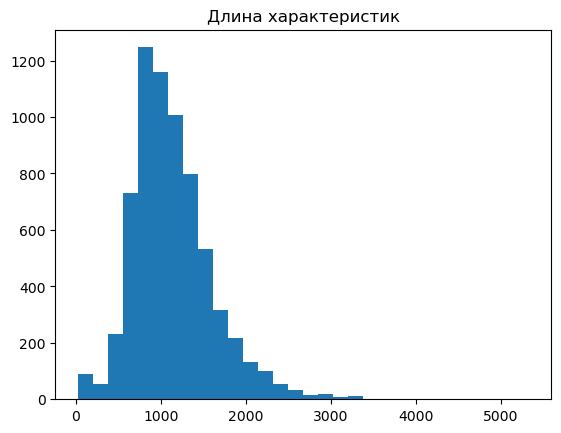

In [6]:
plt.title('Длина характеристик')
plt.hist(list(map(len, df['caracteristics'])), bins=30)
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6756 entries, 0 to 6755
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           6752 non-null   object
 1   article         3146 non-null   object
 2   price           6756 non-null   int64 
 3   cat_1           6756 non-null   object
 4   cat_2           6756 non-null   object
 5   cat_3           6755 non-null   object
 6   description     3837 non-null   object
 7   caracteristics  6756 non-null   object
 8   source          6756 non-null   object
 9   date            6141 non-null   object
 10  url             6468 non-null   object
dtypes: int64(1), object(10)
memory usage: 580.7+ KB


In [8]:
df.isnull().sum()

title                4
article           3610
price                0
cat_1                0
cat_2                0
cat_3                1
description       2919
caracteristics       0
source               0
date               615
url                288
dtype: int64

In [9]:
df1 = pd.read_csv('comparable_data.csv', index_col = 0)
df1 = df1.dropna(subset=['caracteristics', 'price', 'article'])
df1 = df1.drop_duplicates()
df1['cat_2'] = df1['cat_2'].apply(lambda x: str(x).strip())
df1['cat_1'] = df1['cat_1'].apply(lambda x: str(x).replace('Тренажры', 'Тренажеры'))
df1['caracteristics'] = df1['caracteristics'].apply(lambda x: str(x).replace('Читать обзор на товар', '').strip())
df1['price'] = df1['price'].astype(int)
df1 = df1.reset_index(drop=True)
df1[100:101].head(3).style.format({'url': show_image, **{'width': '200px'}})

,title,article,price,cat_1,cat_2,cat_3,url,description,caracteristics,source,date
100,Беговая дорожка Titanium Masters Physiotech A360,400123365,69990,Тренажеры,Беговые дорожки,Titanium,,"Беговая дорожка Titanium Masters Physiotech A360 оснащена дополнительными кнопками управления на поручнях. Там же расположены датчики пульса. Можно отслеживать их показания на большом электронном дисплее. Тренажер подходит для спортсменов, чей вес не превышает 140 кг. Размеры бегового полотна — 132х47 см. Модель оборудована двигателем мощностью 3 л.с, разгоняющим устройство до 18 км/ч. Возможно изменять угол наклона для увеличения или уменьшения желаемой нагрузки. Тренажер складывается пополам и в таком положении занимает в два раза меньше места. Для транспортировки беговой дорожки по квартире предусмотрены колесики. Габариты — 178х76х29,5 см. Вес — 64 кг.",Гарантия 1 год Страна Китай Длина полотна 132 см Максимальный вес пользователя 140 кг Ширина полотна 47 см Максимальная скорость 18 км/ч Регулировка угла наклона Да Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да Питание от сети 220 В Да Глубина 178 см Ширина 76 см Высота 29.5 см Вес 64.22 кг Цвет черный,www.mvideo.ru,2023-08-16


In [10]:
df1 = df1[df1['cat_2'] != 'Степперы']
df1 = df1.reset_index(drop=True)

In [11]:
df1['cat_2'].value_counts()

Беговые дорожки    166
Name: cat_2, dtype: int64

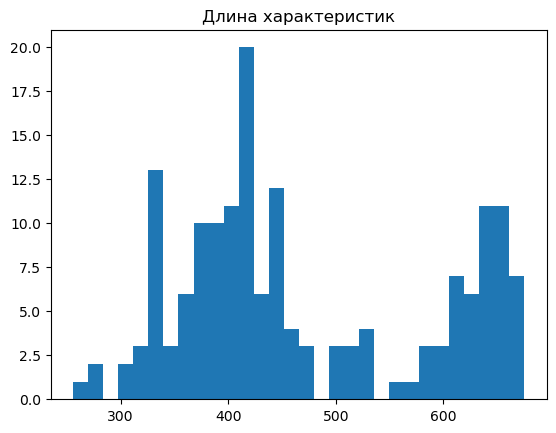

In [12]:
plt.title('Длина характеристик')
plt.hist(list(map(len, df1['caracteristics'])), bins=30)
plt.show()

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166 entries, 0 to 165
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           166 non-null    object
 1   article         166 non-null    int64 
 2   price           166 non-null    int32 
 3   cat_1           166 non-null    object
 4   cat_2           166 non-null    object
 5   cat_3           166 non-null    object
 6   url             166 non-null    object
 7   description     131 non-null    object
 8   caracteristics  166 non-null    object
 9   source          166 non-null    object
 10  date            166 non-null    object
dtypes: int32(1), int64(1), object(9)
memory usage: 13.7+ KB


In [14]:
df1.isnull().sum()

title              0
article            0
price              0
cat_1              0
cat_2              0
cat_3              0
url                0
description       35
caracteristics     0
source             0
date               0
dtype: int64

In [15]:
own_articles = list(df1['article'])

# Уменьшение описаний с помощью выборки основных характеристик

Буду использовать https://pypi.org/project/thefuzz/

Levenshtein distance. 

It’s a metric named after Vladimir Levenshtein, who originally considered it in 1965 to measure the difference between two sequences of words. We can use it to discover the minimum number of edits that you need to do to change a one-word sequence into the other. 

he similarity score is a number between 0 and 100, where 0 means the strings are completely dissimilar and 100 means they are identical.

In [16]:
from thefuzz import fuzz
from nltk import ngrams

def find_text(target, text, threshhold):
    combo = []
    for n in range(3,8): 
        n_grams = ngrams(text.split(), n)
        for grams in n_grams:
            temp = ' '.join(grams)
            combo.append(temp)
    score_lst = []
    for item in combo:
        score = fuzz.ratio(target, item)
        score_lst.append(score)

    ind = np.argwhere(score_lst)
    match = sorted(zip(score_lst, ind.tolist()), reverse=True)
    if (len(match) == 0) or (match[0][0]<threshhold):
        return None
    else:
        return combo[match[0][1][0]]

In [17]:
%%time
df['weight'] = df['caracteristics'].apply(lambda x: find_text('максимальный вес пользователя кг 1234567890 кг', x, 60))
df['speed'] = df['caracteristics'].apply(lambda x: find_text('максимальная скорость км/ч 1234567890 км/ч', x, 60))
df['len'] = df['caracteristics'].apply(lambda x: find_text('длина бегового полотна см 1234567890 см', x, 60))
df['wid'] = df['caracteristics'].apply(lambda x: find_text('ширина бегового полотна см 1234567890 см', x, 60))
df['dist'] = df['caracteristics'].apply(lambda x: find_text('индикация дистанции Да', x, 60))
df['calories'] = df['caracteristics'].apply(lambda x: find_text('индикация расхода калорий Да', x, 60))
df['capacity'] = df['caracteristics'].apply(lambda x: find_text('мощность двигателя л.с. 1234567890 л.с.', x, 60))
df['display'] = df['caracteristics'].apply(lambda x: find_text('цифровой дисплей', x, 60))

CPU times: total: 57.1 s
Wall time: 57.4 s


In [18]:
df = df.fillna('')

In [19]:
%%time
df1['weight'] = df1['caracteristics'].apply(lambda x: find_text('максимальный вес пользователя кг 1234567890 кг', x, 60))
df1['speed'] = df1['caracteristics'].apply(lambda x: find_text('максимальная скорость км/ч 1234567890 км/ч', x, 60))
df1['len'] = df1['caracteristics'].apply(lambda x: find_text('длина бегового полотна см 1234567890 см', x, 60))
df1['wid'] = df1['caracteristics'].apply(lambda x: find_text('ширина бегового полотна см 1234567890 см', x, 60))
df1['dist'] = df1['caracteristics'].apply(lambda x: find_text('индикация дистанции Да', x, 60))
df1['calories'] = df1['caracteristics'].apply(lambda x: find_text('индикация расхода калорий Да', x, 60))
df1['capacity'] = df1['caracteristics'].apply(lambda x: find_text('мощность двигателя л.с. 1234567890 л.с.', x, 60))
df1['display'] = df1['caracteristics'].apply(lambda x: find_text('цифровой дисплей', x, 60))

CPU times: total: 453 ms
Wall time: 441 ms


In [20]:
df1 = df1.fillna('')

In [21]:
df['wid'].value_counts()

                                      1061
Ширина бегового полотна, см 40         214
Ширина бегового полотна 40 см          185
Ширина бегового полотна, см 42         169
Ширина бегового полотна, см 51         157
                                      ... 
бегового полотна: 156 x 51 см            1
бегового полотна (см): 40 х 120 см       1
бегового полотна: 1570 мм                1
бегового полотна 580 х 1570 мм           1
Ширина бегового полотна, см 564          1
Name: wid, Length: 1219, dtype: int64

# Варианты векторного представления:

1. Только названия товаров (title)
2. Название + 3 категории
3. Название товаров + характеристики (полные)
4. Название товаров + характеристики (частичные)

In [22]:
from sentence_transformers import SentenceTransformer
from scipy import sparse

model = SentenceTransformer('sentence-transformers/LaBSE')

In [23]:
from tqdm import tqdm_notebook
data_vect_lst = []
competitors_vect_lst = []

txt_combinations = [['title'],['title', 'cat_1','cat_2','cat_3'],['title', 'caracteristics'], 
                    ['title','weight', 'speed', 'len', 'wid', 'dist', 'calories', 'capacity', 'display']]

combo_names = ['Title_only', 'Title + cat', 'Title + full character', 'Title + short character']

for i in tqdm_notebook(txt_combinations):
    data_vect = model.encode(df1[i].astype(str).agg(' '.join, axis=1).tolist(), normalize_embeddings=True)
    data_vect_lst.append(data_vect)
    competitors_vect = model.encode(df[i].astype(str).agg(' '.join, axis=1).tolist(), normalize_embeddings=True)
    competitors_vect_lst.append(competitors_vect)

print(len(data_vect_lst))
print(len(competitors_vect_lst))

  0%|          | 0/4 [00:00<?, ?it/s]

4
4


In [24]:
def search_similar(article, data, competitors,data_vect, competitors_vect, sim_threshhold):
    """article - item to review from own dat
       data - dataframe with own products
       competitors - dataframe with competitors' products
       data_vect - data in vectorized form
       competitors_vect - competitors data in vectorized form
       sim_threshhold - min similarity score to be inlcuded in recommendation"""

    #print(f'Article to be reviewed: {article}')
    query = data[data['article'] == article]
    
    data_emb = sparse.csr_matrix(data_vect)
    competitors_emb = sparse.csr_matrix(competitors_vect)

    #display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '100px'}}))
    index = query.index[0]
    

    similarity = cosine_similarity(data_emb[index], competitors_emb).flatten()
    ind = np.argwhere(similarity > sim_threshhold)

    if ind.shape[0] == 0:
        print('No items to compare in the sampling!')

    else:
        scores = similarity[similarity > sim_threshhold]
        match = sorted(zip(scores, ind.tolist()), reverse=True)
        temp = pd.DataFrame()
        temp_lst = []
        temp = temp.append(competitors.iloc[match[0][1]][['title', 'price','caracteristics', 'url', 'source']])
        temp_lst.append(round(match[0][0], 2))
       
        try:
            temp = temp.append(competitors.iloc[match[1][1]][['title', 'price','caracteristics', 'url', 'source']])
            temp_lst.append(round(match[1][0], 2))           
        except:
            print('No top 2 identified!')
            
        try:
            temp = temp.append(competitors.iloc[match[2][1]][['title', 'price','caracteristics', 'url', 'source']])
            temp_lst.append(round(match[2][0], 2))           
        except:
            print('No top 3 identified!')
    temp['sim_score'] = temp_lst
    display(temp.style.format({'url': show_image, **{'width': '200px'}}))

In [25]:
article = random.choice(own_articles)
query = df1[df1['article'] == article]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = article, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
12,Беговая дорожка Orlauf Star,99990,Гарантия 2 года Страна Китай Обратите внимание В амортизацию входит сразу несколько систем Удачное решение Клавиши управления на корпусе и консоли. Важная особенность Инновационная система подачи смазки Пользователи оценят В программном пакете 12 тренировок и BodyFat Хорошо придумано Все надписи и указатели русифицированы. Длина полотна 140 см Максимальный вес пользователя 150 кг Ширина полотна 51 см Максимальная скорость 20 км/ч Мощность двигателя (л.с.) 3.5 Регулировка угла наклона 15 * Регулировка угла наклона Да Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да,


Similar search results for text combination Title_only:


,title,price,caracteristics,url,source,sim_score
3093,Беговая дорожка Orlauf Star,99900,"Тип дорожки Электрическая Конструкция тренажера Складная Мощность двигателя, л.с. 3.5 Максимальный вес пользователя, кг 150 Длина бегового полотна, см 140 Ширина бегового полотна, см 51 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 20 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Приборная панель Описание дисплея L C D дисплей показывает время, дистанция, скорость, калории, пульс, жироанализатор Body Fat Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 12 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Система автоматической смазки Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 179 Ширина товара, см 87 Высота товара, см 148 Вес товара, кг 80 Длина в сложенном состоянии, см 128 Ширина в сложенном состоянии, см 87 Высота в сложенном состоянии, см 148 Длина в упаковке, см 190 Ширина в упаковке, см 90 Высота в упаковке, см 43 Вес в упаковке, кг 92 Производитель Бренд Orlauf Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,1.000000
2276,Беговая дорожка Orlauf Star,99900,"Макс. вес пользователя: 150 кг Двигатель: MaxiKraft – 3,5 л.с. Размеры бегового полотна: 140 x 51 см Материал бегового полотна: SchrittBindTM – ультрацепкий, антискользящий рисунок протектора Диапазон скорости бегового полотна: 0,8 — 20 км/ч Система амортизации: ElastizitätTM – 8 цилиндрических эластомеров, 4 амортизирующие супер-подушки и 2 больших эластомера с пружинами на ножках Система регулировки угла наклона: Электронная, без прерывания тренировки Возможное положение угла наклона: 0 — 15 % Управление: Консоль с LCD-дисплеем Русификация клавиш панели управления: да Количество программ тренировок: 12 – одобрены Humboldt University zu Berlin Измерение пульса: Сенсорные кардиодатчики + беспроводной приемник PolarTM AUX-вход и встроенные колонки: да Управление аудио-проигрывателем: да USB-разъем для зарядки устройств: да Полуавтоматическая дозаправка смазкой MilderundTM: да Дополнительные маневренные колесики: да Габариты: Габариты в сложенном виде: 128х87х148 см Габариты в разложенном виде: 179х87х148 см Габариты транспортировочной упаковки:190 х 90 х 43 см Масса нетто: 95 кг Масса брутто: 105 кг",,www.zonasporta.ru,1.000000
3094,Беговая дорожка Orlauf Stellar,49900,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 130 Длина бегового полотна, см 120 Ширина бегового полотна, см 47 Тип регулировки угла наклона Механическая Угол наклона 0 - 4 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Приборная панель Описание дисплея L E D-дисплей (время тренировки, дистанция, скорость, угол наклона, калории, пульс, F A T)Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 17 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 131 Ширина товара, см 74 Высота товара, см 137 Вес товара, кг 45 Длина в сложенном состоянии, см 73 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 137 Длина в упаковке, см 141 Ширина в упаковке, см 77 Высота в упаковке, см 23 Вес в упаковке, кг 52 Производитель Бренд Orlauf Гарантия 24 месяца Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.930000


Similar search results for text combination Title + cat:


,title,price,caracteristics,url,source,sim_score
3093,Беговая дорожка Orlauf Star,99900,"Тип дорожки Электрическая Конструкция тренажера Складная Мощность двигателя, л.с. 3.5 Максимальный вес пользователя, кг 150 Длина бегового полотна, см 140 Ширина бегового полотна, см 51 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 20 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Приборная панель Описание дисплея L C D дисплей показывает время, дистанция, скорость, калории, пульс, жироанализатор Body Fat Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 12 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Система автоматической смазки Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 179 Ширина товара, см 87 Высота товара, см 148 Вес товара, кг 80 Длина в сложенном состоянии, см 128 Ширина в сложенном состоянии, см 87 Высота в сложенном состоянии, см 148 Длина в упаковке, см 190 Ширина в упаковке, см 90 Высота в упаковке, см 43 Вес в упаковке, кг 92 Производитель Бренд Orlauf Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.980000
3094,Беговая дорожка Orlauf Stellar,49900,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 130 Длина бегового полотна, см 120 Ширина бегового полотна, см 47 Тип регулировки угла наклона Механическая Угол наклона 0 - 4 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Приборная панель Описание дисплея L E D-дисплей (время тренировки, дистанция, скорость, угол наклона, калории, пульс, F A T)Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 17 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 131 Ширина товара, см 74 Высота товара, см 137 Вес товара, кг 45 Длина в сложенном состоянии, см 73 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 137 Длина в упаковке, см 141 Ширина в упаковке, см 77 Высота в упаковке, см 23 Вес в упаковке, кг 52 Производитель Бренд Orlauf Гарантия 24 месяца Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.950000
2276,Беговая дорожка Orlauf Star,99900,"Макс. вес пользователя: 150 кг Двигатель: MaxiKraft – 3,5 л.с. Размеры бегового полотна: 140 x 51 см Материал бегового полотна: SchrittBindTM – ультрацепкий, антискользящий рисунок протектора Диапазон скорости бегового полотна: 0,8 — 20 км/ч Система амортизации: ElastizitätTM – 8 цилиндрических эластомеров, 4 амортизирующие супер-подушки и 2 больших эластомера с пружинами на ножках Система регулировки угла наклона: Электронная, без прерывания тренировки Возможное положение угла наклона: 0 — 15 % Управление: Консоль с LCD-дисплеем Русификация клавиш панели управления: да Количество программ тренировок: 12 – одобрены Humboldt University zu Berlin Измерение пульса: Сенсорные кардиодатчики + беспроводной приемник PolarTM AUX-вход и встроенные колонки: да Управление аудио-проигрывателем: да USB-разъем для зарядки устройств: да Полуавтоматическая дозаправка смазкой MilderundTM: да Дополнительные маневренные колесики: да Габариты: Габариты в сложенном виде: 128х87х148 см Габариты в разложенном виде: 179х87х148 см Габариты транспортировочной упаковки:190 х 90 х 43 см Масса нетто: 95 кг Масса брутто: 105 кг",,www.zonasporta.ru,0.950000


Similar search results for text combination Title + full character:


,title,price,caracteristics,url,source,sim_score
5100,Беговая дорожка EVO FITNESS Power,96990,"Вес 105 кг Производитель Эво Фитнесс Страна изготовления КНР Складной Да электрическая Максимальный вес пользователя 160 кг Длина бегового полотна 145 см Система складывания пневматическая система Консоль LED панель со встроенным модулем управления Количество программ тренировки 12 Отображение пульса есть Система автоматической смазки есть Толщина деки 20 мм В комплекте Набор ключей для сборки Инструкция на русском языке Мультимедийные возможности воспроизведение аудио файлов (2 встроенных динамика) Питание сетевое 220 Вольт Размер (ДхШхВ) 204 х 92,5 х 138 Размеры (транспортные габариты) (ДхШхВ) 207 х 97 х 44 Производитель EVO Fitness Вес с упаковкой 118 кг Страна бренда Германия Гарантия 24 мес. Тип товара Беговая дорожка Двигатель (л.с.) 3,5 Ширина бегового полотна 58 см Скорость движения бегового полотна (км/ч) 1-20 автоматическая 0-15% Показания время, дистанция, пульс, расход калорий, скорость Измерение пульса Сенсорные датчики система из 8 эластомеров и 2х амортизаторов Light CushionTM (амортизация всей поверхности полотна, уменьшение нагрузки на суставы и позвоночник) Рама (материал) усиленная, с двухслойной порошковой покраской Удобства Транспортировочные ролики Вентилятор нет Возможность профессионального использования нет (домашний) Прочее Разъемы USB, AUX Смазка для бегового полотна есть (силиконовая, 4 шт) Система смазки бегового полотна есть, автоматическая система распределения смазки Размер в сложенном виде (ДхШхВ) 145 х 92 х 128",,https://petrasport.ru,0.760000
5097,Беговая дорожка PHANTOM 31,96120,"Вес 136 кг Страна бренда США Гарантия 18 мес. электрическая Максимальный вес пользователя 170 кг Ширина бегового полотна 55 см до 20 км/ч Конструкция Монолит Консоль Встроенный многофункциональный 10-ти дюймовый LCD-дисплей с синей фоновой подсветкой Измерение пульса Сенсорные датчики измерения пульса на рукоятках Отображение расхода калорий да Отображение времени тренировки да Инновационная система амортизации: Блок из 8-ми амортизаторов TSA в сочетании с дополнительными эластичными амортизаторами Удобства Программы: 24 основных эффективных тренировочных программ+3 пользовательских + 1 ручная, быстрая регулировка скорости и угла наклона. Возможность профессионального использования есть Размер (ДхШхВ) 220x88x148 см. Производитель Eurofit Производитель Еурофит Страна изготовления Тайвань Тип товара Беговая дорожка Двигатель (л.с.) 4 Размеры бегового полотна (см) 55х150 см Длина бегового полотна 150 см Максимальная скорость движения бегового полотна 20 км/ч 0-15% Количество программ тренировки 28 Отображение пульса да Отображение текущей скорости да Отображение пройденного расстояния да Рама (материал) Высококачественная сталь Вентилятор да Питание сеть 220 Вольт Складной Нет",,https://petrasport.ru,0.760000
3696,Беговая дорожка Optima Fitness Walker,31230,Тип электрическая Уровень базовый Габариты (ДхШхВ) 123.5 х 63 х 123 см Вес тренажера 38 кг Вес в упаковке 45 кг Возможность складывания есть Габариты в сложенном виде 151.5 х 72 х 86.5 см Тип питания сеть 220 Вольт Происхождение марки Германия Страна-производитель Китай Гарантия 2 года Количество программ 12 Измерение пульса сенсорные датчики Двигатель 1.25 л.с. Максимальная скорость 12 км/ч Максимальный вес пользователя 115 кг Беговое полотно 15 мм Размеры полотна (ДхШ) 120 х 40 Толщина деки 1.4 мм Возможный наклон 3 уровня Регулировка наклона механическая Амортизация Air Cushion S Дисплей LCD Отображение времени тренировки есть Отображение пройденного расстояния есть Отображение пульса есть Отображение расхода калорий есть Отображение текущей скорости есть Система складывания Easy Drop System Транспортировочные ролики есть Дополнительно Функция Body Fat Диаметр передние/задние ролики: 42 мм,,www.beg-dorozhki.ru,0.760000


Similar search results for text combination Title + short character:


,title,price,caracteristics,url,source,sim_score
3093,Беговая дорожка Orlauf Star,99900,"Тип дорожки Электрическая Конструкция тренажера Складная Мощность двигателя, л.с. 3.5 Максимальный вес пользователя, кг 150 Длина бегового полотна, см 140 Ширина бегового полотна, см 51 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 20 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Приборная панель Описание дисплея L C D дисплей показывает время, дистанция, скорость, калории, пульс, жироанализатор Body Fat Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 12 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Система автоматической смазки Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 179 Ширина товара, см 87 Высота товара, см 148 Вес товара, кг 80 Длина в сложенном состоянии, см 128 Ширина в сложенном состоянии, см 87 Высота в сложенном состоянии, см 148 Длина в упаковке, см 190 Ширина в упаковке, см 90 Высота в упаковке, см 43 Вес в упаковке, кг 92 Производитель Бренд Orlauf Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.900000
3094,Беговая дорожка Orlauf Stellar,49900,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 130 Длина бегового полотна, см 120 Ширина бегового полотна, см 47 Тип регулировки угла наклона Механическая Угол наклона 0 - 4 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Наличие амортизации Да Приборная панель Описание дисплея L E D-дисплей (время тренировки, дистанция, скорость, угол наклона, калории, пульс, F A T)Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 17 Удобства Сенсорные датчики Да Анализатор массы тела Body Fat Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Цвет Черный Габариты и вес Длина товара, см 131 Ширина товара, см 74 Высота товара, см 137 Вес товара, кг 45 Длина в сложенном состоянии, см 73 Ширина в сложенном состоянии, см 74 Высота в сложенном состоянии, см 137 Длина в упаковке, см 141 Ширина в упаковке, см 77 Высота в упаковке, см 23 Вес в упаковке, кг 52 Производитель Бренд Orlauf Гарантия 24 месяца Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.830000
1075,Беговая дорожка Alpha Fitness Comfort,33350,"Тип беговой дорожки: электрическая Макс. вес пользователя: 140 кг Складная Постоянная мощность двигателя: 3.0 л.с. Максимальная скорость движения: 20 км/ч Минимальная скорость движения: 1 км/ч Макс. угол наклона полотна: 15 Минимальный угол наклона полотна: 1 Длина бегового полотна: 142 см Ширина бегового полотна: 51 см Измерение пульса: датчики пульса на поручнях, нагрудный кардиодатчик Питание: 220 В Количество программ тренировки: 18 Пользовательские программы: 3 Отображение времени тренировки Отображение текущей скорости Отображение расхода калорий Отображение пульса Отображение пройденного расстояния Транспортировочные ролики/колеса Монитор: голубой многофункциональный LCD дисплей Толщина деки: 22 мм Пиковая мощность двигателя: 4.5 л.с. Беговое полотно: 2х слойное, 2.0 мм Габариты: ДхШхВ: 185х82х132 см Размеры в сложенном виде, см (ДхШхВ): 113х82х163 см Размеры упаковки: 199.5х84х37.5 см Вес нетто: 89 кг Вес брутто (в упаковке): 102 кг",,www.zonasporta.ru,0.810000


In [26]:
article = random.choice(own_articles)
query = df1[df1['article'] == article]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = article, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
26,Беговая дорожка UnixFit R-280,29890,Гарантия 2 года Страна Китай Длина полотна 108 см Максимальный вес пользователя 110 кг Ширина полотна 41 см Максимальная скорость 10 км/ч Мощность двигателя (л.с.) 1.25 Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Колесики для перемещения Да Питание от сети 220 В Да Глубина 73 см Ширина 130 см Высота 103 см Вес 32 кг Цвет черный/ серый,


Similar search results for text combination Title_only:


,title,price,caracteristics,url,source,sim_score
444,Беговая дорожка UnixFit R-280,29890,"Возможность профессионального использования:Нет Торговая марка:UnixFit Вес, кг:32 Габариты в сложенном виде (ДхШхВ), см:130х73x14 Габариты (ДхШхВ), cм:130х73х103 Гарантийный срок, мес: 24 Вес с упаковкой, кг:35.2 Габариты упаковки (ДхШхВ), см:149x73x17 Общий объем товара, м3:0.1849: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 41 Тип: электрические Максимальный вес пользователя, кг: 110 Длина бегового полотна, см: 108 Мин. скорость движения, км/ч.:0.8 Макс. скорость движения, км/ч: 10 Складная: Да: Программы:Возможность программирования тренировки: Нет: Техническая информация:Толщина бегового полотна, мм:1.6 Толщина деки, мм:14 Мощность двигателя, л.с.: 1.25 Регулировка угла наклона: нет Пиковая мощность двигателя, л.с.:1.75 Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Измерение пульса: Нет: Дополнительная информация:Без поручней:Да Вентилятор: Нет Динамики: Да Подставка для книг\планшета: Да Подставка для стакана: Нет Транспортировочные ролики/колеса: Да:",,www.domsporta.ru,1.000000
2335,Беговая дорожка UNIXFit R-280,30890,"Тип дорожки:для домашнего использования Скорость:0.8 – 10 км/ч Мощность двигателя:1.25 л.с. Shlümdenger Electric (постоянный ток DC)Пиковая мощность двигателя:1.75 л.с.Беговое полотно:двухслойное антискользящее покрытие (толщина 1.6 мм)Размер бегового полотна (Дх Ш):108 х 41 см Дека:14 мм.Система амортизации:4 плоских эластомеров, 2 амортизирующих суппорта NANO Elastic® (снижают нагрузку на позвоночник и суставы)Измерение пульса:нет Консоль:стикер (4 окна), голубая подсветка (LED дисплей)Показания консоли:время, скорость, дистанция, калории Кол-во программ:нет Интеграция и Мультимедиа:Bluetooth, 2 встроенных динамика Питание:сеть 220 Вольт Складывание:есть, компактное Габариты (Дх Шх В):в рабочем состоянии 1300 х 730 х 1030 мм.; в сложенном 1300 х 730 х 140 мм.; в упаковке 1490 x 730 x 170 мм.Вес:нетто 32 кг.Максимальный вес пользователя:110 кг.Рама:особопрочная с двухслойной покраской Дополнительные характеристики:транспортировочные ролики, подставка под планшет, пульт Д У, смазка для бегового полотна, электрическая система распределения смазки Гарантия:2 года + 3 года на раму Производитель:UNIXFITTMСтрана изготовления:К Н Р",,www.sportdoma.ru,0.970000
826,Беговая дорожка Unixfit R-280,30890,"Назначение домашнее Рама особопрочная с двухслойной покраской Скорость 0.8 – 10 км/ч Двигатель 1.25 л.с. Shlümdenger Electric (постоянный ток DC) Система охлаждения двигателя есть (воздушное) Уровень шума двигателя низкий (система шумоподавления Smartex) Пиковая мощность двигателя 1.75 л.с. Беговое полотно двухслойное антискользящее покрытие (толщина 1.6 мм) Размер бегового полотна 108х41 см Дека 14 мм Система амортизации 4 плоских эластомеров, 2 амортизирующих суппорта NANO Elastic® (снижают нагрузку на позвоночник и суставы) Измерение пульса нет Консоль стикер (4 окна), голубая подсветка (LED дисплей) Пульт ДУ есть Показания консоли время, скорость, дистанция, калории Кол-во программ нет Подставка под планшет есть Инструкция по сборке есть (на русском языке) Мультимедиа Bluetooth, 2 встроенных динамика Транспортировочные ролики есть Инструмент для сборки не требует сборки Смазка для бегового полотна есть (силиконовая, 2 шт) Система смазки бегового полотна есть, электрическая система распределения смазки Складывание есть, компактное Максимальный вес пользователя 110 кг Питание сеть 220 Вольт Энергосбережение есть (класс А+) Гарантия на раму 3 года Гарантия 2 года Сертификаты CE, RoHS Производитель UNIXFITTM Страна изготовления КНР Габариты: Размер упаковки 1490 x 730 x 170 мм Размер в сложенном виде (Д*Ш*В) 1300 х 730 х 140 мм Размер в рабочем состоянии (Д*Ш*В) 1300 х 730 х 1030 мм Вес нетто 32 кг",,www.zonasporta.ru,0.9600

Similar search results for text combination Title + cat:


,title,price,caracteristics,url,source,sim_score
444,Беговая дорожка UnixFit R-280,29890,"Возможность профессионального использования:Нет Торговая марка:UnixFit Вес, кг:32 Габариты в сложенном виде (ДхШхВ), см:130х73x14 Габариты (ДхШхВ), cм:130х73х103 Гарантийный срок, мес: 24 Вес с упаковкой, кг:35.2 Габариты упаковки (ДхШхВ), см:149x73x17 Общий объем товара, м3:0.1849: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 41 Тип: электрические Максимальный вес пользователя, кг: 110 Длина бегового полотна, см: 108 Мин. скорость движения, км/ч.:0.8 Макс. скорость движения, км/ч: 10 Складная: Да: Программы:Возможность программирования тренировки: Нет: Техническая информация:Толщина бегового полотна, мм:1.6 Толщина деки, мм:14 Мощность двигателя, л.с.: 1.25 Регулировка угла наклона: нет Пиковая мощность двигателя, л.с.:1.75 Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Измерение пульса: Нет: Дополнительная информация:Без поручней:Да Вентилятор: Нет Динамики: Да Подставка для книг\планшета: Да Подставка для стакана: Нет Транспортировочные ролики/колеса: Да:",,www.domsporta.ru,0.990000
2667,Беговая дорожка UNIXFIT R-280,30272,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Компактная Описание электродвигателя Shlumdenger Electric (постоянный ток D C)Мощность двигателя, л.с. 1.25 Максимальный вес пользователя, кг 110 Длина бегового полотна, см 108 Ширина бегового полотна, см 41 Максимальная скорость, км/ч 10 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Система амортизации 4 плоских эластомеров, 2 амортизирующих суппорта N A N O Elastic® (снижают нагрузку на позвоночник и суставы)Приборная панель Описание дисплеястикер ( 4 окна), голубая подсветка (L E D дисплей)Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание мультимедиа Bluetooth, 2 встроенных динамика Удобства Подставка для планшета / книги Да Транспортировочные ролики Да Пульт дистанционного управления Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Есть (класс А+)Пиковая мощность двигателя, л.с. 1.75 Уровень шума Низкий (система шумоподавления Smartex)Характеристики бегового полотна Двухслойное антискользящее покрытие (толщина 1.6 мм)Толщина деки, мм 14 Описание рамыособопрочная с двухслойной покраской Цвет Серый Габариты и вес Длина товара, см 130 Ширина товара, см 73 Высота товара, см 103 Вес товара, кг 32 Длина в сложенном состоянии, см 130 Ширина в сложенном состоянии, см 73 Высота в сложенном состоянии, см 14 Длина в упаковке, см 149 Ширина в упаковке, см 73 Высота в упаковке, см 17 Производитель Бренд Unix Fit Гарантия Гарантия 2 года, на раму 3 года Производство К Н Р",,www.mir-sporta.ru,0.980000
347,Беговая дорожка UnixFit R-280P,33890,"Возможность профессионального использования:Нет Торговая марка:UnixFit Вес, кг:32 Габариты в сложенном виде (ДхШхВ), см:130х73х14 Габариты (ДхШхВ), cм:130x73x103 Гарантийный срок, мес: 24 Вес с упаковкой, кг:35 Габариты упаковки (ДхШхВ), см:149x73x17 Общий объем товара, м3:0.1849: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 41 Тип: электрические Максимальный вес пользователя, кг: 110 Длина бегового полотна, см: 108 Мин. скорость движения, км/ч.:0.8 Макс. скорость движения, км/ч: 10 Складная: Да: Техническая информация:Толщина деки, мм:14 Мощность двигателя, л.с.: 1.25 Пиковая мощность двигателя, л.с.:1.75 Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Измерение пульса: Нет: Дополнительная информация:Динамики: Да Транспортировочные ролики/колеса: Да:",,www.domsporta.ru,0.970000


Similar search results for text combination Title + full character:


,title,price,caracteristics,url,source,sim_score
171,"Беговая дорожка UNIXFIT R-280 для дома, складная, электрическая. Мощность 1,25 л.с., вес до 110 кг., беговое полотно 108x41 см, скорость 0.8 - 10 км/ч, 4 плоских эластомеров, 2 амортизирующих суппорта NANO Elastic, гарантия 2 года",29890,"Габариты и вес Ширина бегового полотна, см 41 Длина бегового полотна, см 108 Ширина, см 73 Длина, см 130 Вес товара, г 35000 Высота, см 103 Кол-во программ 0 Макс. угол наклона полотна, % 0 Страна-изготовитель Китай Класс тренажера Домашний Максимальная скорость, км/ч 10 Максимальный вес пользователя, кг 110 Измерительные датчики Время, Дистанция, Скорость, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд UNIXFIT Цвет Серый Дисплей Консоль стикер (4 окна), голубая подсветка (LED дисплей) Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая Особенности тренажеров: Антискользящее покрытие, Складная конструкция, Транспортировочные ролики Амортизация: 4 плоских эластомеров, 2 амортизирующих суппорта NANO Elastic® (снижают нагрузку на позвоночник и суставы)",,www.ozon.ru,0.810000
5781,Беговая дорожка R-280,23167,Дополнительная информация Максимальный вес пользователя 110 кг Тип беговой дорожки электрическая; складная; бесшумная Максимальная скорость дорожки 10 км/ч Ширина бегового полотна 41 см Страна производства Китай Габариты Ширина предмета 73 см Глубина предмета 130 см Вес без упаковки (кг) 32 кг Вес с упаковкой (кг) 35.2 кг Высота предмета 103 см Длина упаковки 149 см Высота упаковки 17 см Ширина упаковки 73 см Общие характеристики Гарантийный срок 2 (два) года Модель R-280 Технические особенности Мощность (лс) 1.25 лс,,www.wildberries.ru,0.800000
121,Беговая дорожка UNIX Fit ST-350 / мощность 1.25 л.с. / до 110 кг / беговое полотно 103x36 см / скорость 0.9 - 10 км/ч / 6 плоских эластомеров / гарантия 2 года,26890,"Класс тренажера Домашний Максимальная скорость, км/ч 10 Максимальный вес пользователя, кг 110 Измерительные датчики Время, Скорость, Сердечный ритм, Дистанция, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Регулировка угла наклона бегового полотна Электрическая Кол-во программ 12 Макс. угол наклона полотна, % 10 Страна-изготовитель Китай Габариты и вес Ширина бегового полотна, см 36 Длина бегового полотна, см 103 Ширина, см 59 Длина, см 125 Вес товара, г 27000 Высота, см 130 Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд UNIXFIT Цвет Черный Дисплей диагональ 2.5 дюйма (7 см), LED дисплей Гарантийный срок 2 года Система нагрузки беговой дорожки Электрическая Особенности тренажеров: Складная конструкция, Транспортировочные ролики, Антискользящее покрытие, Вертикальное хранение, Компенсатор неровности пола, Нескользящее покрытие ручек Амортизация: 6 плоских эластомеров (снижают нагрузку на позвоночник и суставы)",,www.ozon.ru,0.790000


Similar search results for text combination Title + short character:


,title,price,caracteristics,url,source,sim_score
2667,Беговая дорожка UNIXFIT R-280,30272,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Компактная Описание электродвигателя Shlumdenger Electric (постоянный ток D C)Мощность двигателя, л.с. 1.25 Максимальный вес пользователя, кг 110 Длина бегового полотна, см 108 Ширина бегового полотна, см 41 Максимальная скорость, км/ч 10 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Система амортизации 4 плоских эластомеров, 2 амортизирующих суппорта N A N O Elastic® (снижают нагрузку на позвоночник и суставы)Приборная панель Описание дисплеястикер ( 4 окна), голубая подсветка (L E D дисплей)Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание мультимедиа Bluetooth, 2 встроенных динамика Удобства Подставка для планшета / книги Да Транспортировочные ролики Да Пульт дистанционного управления Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Есть (класс А+)Пиковая мощность двигателя, л.с. 1.75 Уровень шума Низкий (система шумоподавления Smartex)Характеристики бегового полотна Двухслойное антискользящее покрытие (толщина 1.6 мм)Толщина деки, мм 14 Описание рамыособопрочная с двухслойной покраской Цвет Серый Габариты и вес Длина товара, см 130 Ширина товара, см 73 Высота товара, см 103 Вес товара, кг 32 Длина в сложенном состоянии, см 130 Ширина в сложенном состоянии, см 73 Высота в сложенном состоянии, см 14 Длина в упаковке, см 149 Ширина в упаковке, см 73 Высота в упаковке, см 17 Производитель Бренд Unix Fit Гарантия Гарантия 2 года, на раму 3 года Производство К Н Р",,www.mir-sporta.ru,0.900000
2816,Беговая дорожка UNIXFIT R-280P,33212,"Тип дорожки Электрическая Класс тренажера Домашний Конструкция тренажера Складная Описание электродвигателя Shlumdenger Electric (постоянный ток D C)Мощность двигателя, л.с. 1.25 Максимальный вес пользователя, кг 110 Длина бегового полотна, см 108 Ширина бегового полотна, см 41 Максимальная скорость, км/ч 10 Минимальная скорость, км/ч 0.8 Наличие амортизации Да Система амортизации 4 плоских эластомеров, 2 амортизирующих суппорта N A N O Elastic® (снижают нагрузку на позвоночник и суставы)Приборная панель Описание дисплея L C D дисплей Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Описание интеграцийфитнес приложение Kino Map для синхронизации с мобильным устройством и записи тренировок Описание мультимедиа Bluetooth, 2 встроенных динамика Удобства Подставка для планшета / книги Да Транспортировочные ролики Да Система автоматической смазки Да Дополнительные Питание тренажера От сети 220 Вольт Энергосбережениекласс А+Пиковая мощность двигателя, л.с. 1.75 Уровень шума Низкий (система шумоподавления Smartex)Характеристики бегового полотна Двухслойное антискользящее покрытие (толщина 1.6 мм)Толщина деки, мм 14 Описание рамыособопрочная с двухслойной покраской Цвет Серый Габариты и вес Длина товара, см 130 Ширина товара, см 73 Высота товара, см 103 Вес товара, кг 32 Длина в сложенном состоянии, см 130 Ширина в сложенном состоянии, см 73 Высота в сложенном состоянии, см 14 Длина в упаковке, см 149 Ширина в упаковке, см 73 Высота в упаковке, см 17 Вес в упаковке, кг 35 Производитель Бренд Unix Fit Гарантия 2 года",,www.mir-sporta.ru,0.880000
4289,Беговая дорожка UNIXFIT R-280,30890,"Вес 32 кг Страна бренда Германия Гарантия Гарантия на раму 3 года Гарантия 2 года Тип товара Беговая дорожка Двигатель (л.с.) 1.25 л.с Пиковая мощность двигателя 1,75 л.с Характеристики двигателя Shlümdenger Electric (постоянный ток DC) Система охлаждения двигателя есть (воздушное) Уровень шума двигателя низкий (система шумоподавления Smartex) Максимальный вес пользователя 110 кг Ширина бегового полотна 108 см 0,8-10 км/ч Максимальная скорость движения бегового полотна 10 км/ч нет Показания время, скорость, дистанция, калории

In [27]:
article = random.choice(own_articles)
query = df1[df1['article'] == article]
display(query[['title','price','caracteristics', 'url']] .style.format({'url': show_image, **{'width': '200px'}}))
for ind, item  in enumerate(combo_names):
    print(f'Similar search results for text combination {item}:')
    
    search_similar(article = article, 
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.5)

,title,price,caracteristics,url
110,Беговая дорожка Titanium Masters Slimtech S260,68990,Гарантия 1 год Страна Китай Максимальный вес пользователя 120 кг Регулировка угла наклона Да Цифровой дисплей Да Индикация дистанции Да Индикация выбранной скорости Да Индикация расхода калорий Да Индикация пульса Да Колесики для перемещения Да Питание от сети 220 В Да Глубина 164 см Ширина 79 см Высота 30 см Вес 57 кг Цвет черный,


Similar search results for text combination Title_only:


,title,price,caracteristics,url,source,sim_score
3424,Беговая дорожка Titanium Masters Slimtech S260,74990,"Тип электрическая Уровень базовый Габариты (ДхШхВ) 153 х 75 х 128 см Вес тренажера 51 кг Вес в упаковке 57 кг Возможность складывания есть, складывается в плоскость Габариты в сложенном виде 153 х 75 х 25 см Тип питания сеть 220 Вольт Происхождение марки Германия-Израиль Страна-производитель КНР Гарантия 5 лет Количество программ 15 Спецификации программ 12 предустановленных программ, 3 программы обратного отсчета (время, дистанция, калории) Измерение пульса сенсорные датчики Мультимедиа нет Двигатель 2,25 л.с. Fuji ServoTM C-Series (постоянный ток) Пиковая мощность двигателя 3,83 л.с. Максимальная скорость 16 км/ч Максимальный вес пользователя 120 кг Беговое полотно 1,6 мм, многослойное Habasit NНT-216 Размеры полотна (ДхШ) 122 х 43 см Толщина деки 16 мм, парафинированная Возможный наклон 0-15% Регулировка наклона электрическая Амортизация есть Система амортизации 2 полиуретановых амортизатора rubber-HEADSTM + 8 полноразмерных динамических эластомера VCSTM Дисплей 6-ти экранный LED дисплей с сенсорными клавишами Отображение времени тренировки есть Отображение пройденного расстояния есть Отображение пульса есть Отображение расхода калорий есть Отображение текущей скорости есть Система автоматической смазки есть Габариты в упаковке 164 х 79 х 30 см Система складывания компактное складывание true-VERTICALTM Встроенный вентилятор нет Транспортировочные ролики есть Интеграция приложения Fitshow, Fithome, Zwift, Kinomap для смартфонов Дополнительно управление на поручнях, Bluetooth (подключение сторонних приложений), есть зарядка мобильного устройства",,www.beg-dorozhki.ru,1.000000
3129,Беговая дорожка Titanium Masters Slimtech S260,71241,"Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 120 Длина бегового полотна, см 122 Ширина бегового полотна, см 43 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Система амортизации 2 полиуретановых амортизатора rubber-H E A D STM + 8 полноразмерных динамических эластомера V C STMПриборная панель Описание дисплея 6 -ти экранный L E D дисплей с сенсорными клавишами Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 15 Предустановленные программы, шт 12 Удобства Анализатор массы тела Body Fat Да Подставка для планшета / книги Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 3.83 Толщина деки, мм 16 Габариты и вес Длина товара, см 153 Ширина товара, см 75 Высота товара, см 128 Вес товара, кг 51 Длина в сложенном состоянии, см 153 Ширина в сложенном состоянии, см 75 Высота в сложенном состоянии, см 25 Длина в упаковке, см 164 Ширина в упаковке, см 79 Высота в упаковке, см 30 Вес в упаковке, кг 57 Производитель Бренд Titanium Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,1.000000
2574,Беговая дорожка Titanium Masters Slimtech S260,71990,"Тип дорожки:для домашнего использования Скорость:1-16 км/ч Мощность двигателя:2,25 л.с. Fuji ServoTM C-Series (постоянный ток)Пиковая мощность двигателя:3,83 л.с.Беговое полотно:1,6 мм, многослойное Habasit N НT-216 Размер бегового полотна (Дх Ш):122х43 см Регулировка угла наклона:электрическая Наклон бегового полотна:0-15%Дека:16 мм, парафинированная Система амортизации:2 полиуретановых амортизатора rubber-HEADSTM + 8 полноразмерных динамических эластомера VCSTMИзмерение пульса:сенсорные датчики Консоль:6-ти экранный LED дисплей с сенсорными клавишами Показания консоли:время, дистанция, скорость, калории, угол наклона, шаги, пульс, жироанализатор Body Fat Кол-во программ:15 Спецификации программ:12 предустановленных программ, 3 программы обратного отсчет

Similar search results for text combination Title + cat:


,title,price,caracteristics,url,source,sim_score
3129,Беговая дорожка Titanium Masters Slimtech S260,71241,"Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 120 Длина бегового полотна, см 122 Ширина бегового полотна, см 43 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Система амортизации 2 полиуретановых амортизатора rubber-H E A D STM + 8 полноразмерных динамических эластомера V C STMПриборная панель Описание дисплея 6 -ти экранный L E D дисплей с сенсорными клавишами Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 15 Предустановленные программы, шт 12 Удобства Анализатор массы тела Body Fat Да Подставка для планшета / книги Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 3.83 Толщина деки, мм 16 Габариты и вес Длина товара, см 153 Ширина товара, см 75 Высота товара, см 128 Вес товара, кг 51 Длина в сложенном состоянии, см 153 Ширина в сложенном состоянии, см 75 Высота в сложенном состоянии, см 25 Длина в упаковке, см 164 Ширина в упаковке, см 79 Высота в упаковке, см 30 Вес в упаковке, кг 57 Производитель Бренд Titanium Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,1.000000
488,Беговая дорожка Titanium Masters Slimtech S260,71990,"Страна изготовления:Китай Возможность профессионального использования:Нет Торговая марка:Titanium Вес, кг:51 Габариты в сложенном виде (ДхШхВ), см:153x75x25 Габариты (ДхШхВ), cм:153x75x128 Гарантийный срок, мес: 60 Вес с упаковкой, кг:57.14 Габариты упаковки (ДхШхВ), см:164х79х30 Общий объем товара, м3:0.3887: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 43 Тип: электрические Максимальный вес пользователя, кг: 120 Длина бегового полотна, см: 122 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 16 Складная: Да Максимальный угол наклона, %: 15: Программы:Количество программ тренировки: 15: Техническая информация:Толщина бегового полотна, мм:1.6 Толщина деки, мм:16 Мощность двигателя, л.с.: 2.25 Регулировка угла наклона: электронная Пиковая мощность двигателя, л.с.:3.83 Тип регулировки угла наклона: плавная Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение темпа: Да Отображение пройденного расстояния: Да Отображение угла наклона: Да Измерение пульса: Да Кардиодатчик на ручке: Да: Дополнительная информация:Без поручней:Нет Оценка Body Fat: Да Вентилятор: Нет Подставка для книг\планшета: Да Транспортировочные ролики/колеса: Да Компенсаторы неровности пола: Да:",,www.domsporta.ru,1.000000
2137,Беговая дорожка Titanium Masters Slimtech S260,74990,"Назначение: домашнее Тип: электрическая Двигатель:2,25 л.с. Fuji ServoTM C-Series (постоянный ток) Пиковая мощность: 3,83 л.с. Скорость: 1-16 км/ч Беговое полотно:1,6 мм, многослойное Habasit NНT-216 Размер бегового полотна: 122*43 см Регулировка угла наклона:электрическая Угол наклона:0-15% Дека: 16 мм, парафинированная Система амортизации:2 полиуретановых амортизатора rubber-HEADSTM + 8 полноразмерных динамических эластомера VCSTM Консоль:6-ти экранный LED дисплей с сенсорными клавишами Язык(и) интерфейса: английский Показания консоли:время, дистанция, скорость, калории, угол наклона, шаги, пульс, жироанализатор Body Fat Общее количество программ: 15 Тренировочные программы:12 предустановленных программ, 3 программы обратного отсчета (время, дистанция, калории) Пульсозависимые программы: нет Пользовательские программы: нет Ручной режим: есть Мультимедиа: нет Интеграция:приложения Fitshow, Fithome, Zwift, Kinomap для смартфонов Интернет: нет Разъемы и передача данных:Bluetooth (подключени

Similar search results for text combination Title + full character:


,title,price,caracteristics,url,source,sim_score
109,Беговая дорожка Titanium One T22 S,22990,"Габариты и вес Ширина бегового полотна, см 38 Длина бегового полотна, см 100 Ширина, см 56 Длина, см 121 Вес товара, г 15000 Высота, см 12 Страна-изготовитель Китай Класс тренажера Домашний Максимальная скорость, км/ч 8 Максимальный вес пользователя, кг 90 Измерительные датчики Время, Дистанция, Скорость, Расход калорий Питание тренажера Сеть 220 Вольт Целевая аудитория Взрослая Дополнительные Тип Беговая дорожка Форма поставки В разобранном виде Бренд TITANIUM Цвет Черный Особенности тренажеров Без поручней, Транспортировочные ролики, Пульт ДУ Дисплей LED дисплей (в кожухе моторного отсека) Гарантийный срок 3 Система нагрузки беговой дорожки Электрическая",,www.ozon.ru,0.770000
3011,Беговая дорожка Titanium Masters Slimtech S60 (красная),99741,"Тип дорожки Электрическая Максимальный вес пользователя, кг 150 Дополнительные Питание тренажера От сети 220 Вольт Энергосбережение Есть Цвет Красный Дополнительный цвет Черный Габариты и вес Длина товара, см 157 Ширина товара, см 78 Высота товара, см 127 Вес товара, кг 64 Длина в сложенном состоянии, см 177 Ширина в сложенном состоянии, см 78 Высота в сложенном состоянии, см 17 Длина в упаковке, см 180 Ширина в упаковке, см 85.5 Высота в упаковке, см 21.5 Вес в упаковке, кг 72 Производитель Бренд Titanium Гарантия 5 лет Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.760000
3741,Беговая дорожка EVO FITNESS Titan,45990,"Тип электрическая Уровень базовый Габариты (ДхШхВ) 171 х 72 х 129 см Вес тренажера 66 кг Вес в упаковке 74 кг Возможность складывания есть Габариты в сложенном виде 98 х 72 х 141 см Тип питания сеть 220 Вольт Страна-производитель КНР Гарантия 2 года Количество программ 15 Измерение пульса сенсорные датчики Двигатель 3.0 л.с. Максимальная скорость 16 км/ч Максимальный вес пользователя 140 кг Беговое полотно 1.6 мм Размеры полотна (ДхШ) 126 х 46 см Толщина деки 18 мм Возможный наклон 0-15% Регулировка наклона электрическая Амортизация есть Система амортизации Light CushuonTM Дисплей многофункциональный LCD дисплей Отображение времени тренировки есть Отображение пройденного расстояния есть Отображение пульса есть Отображение расхода калорий есть Отображение текущей скорости есть Габариты в упаковке 178 х 76 х 35 см Рама в основе конструкции рамы использована сталь с двойным порошковым покрытием Транспортировочные ролики есть Интеграция возможность подключения MP3, 2 встроенных динамика, разъем AUX для аудионосителей (провод AUX в комплекте), разъем USB (для зарядки мобильных устройств) Дополнительно набор ключей для сборки в комплекте Вес нетто 66 кг",,www.beg-dorozhki.ru,0.750000


Similar search results for text combination Title + short character:


,title,price,caracteristics,url,source,sim_score
488,Беговая дорожка Titanium Masters Slimtech S260,71990,"Страна изготовления:Китай Возможность профессионального использования:Нет Торговая марка:Titanium Вес, кг:51 Габариты в сложенном виде (ДхШхВ), см:153x75x25 Габариты (ДхШхВ), cм:153x75x128 Гарантийный срок, мес: 60 Вес с упаковкой, кг:57.14 Габариты упаковки (ДхШхВ), см:164х79х30 Общий объем товара, м3:0.3887: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 43 Тип: электрические Максимальный вес пользователя, кг: 120 Длина бегового полотна, см: 122 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 16 Складная: Да Максимальный угол наклона, %: 15: Программы:Количество программ тренировки: 15: Техническая информация:Толщина бегового полотна, мм:1.6 Толщина деки, мм:16 Мощность двигателя, л.с.: 2.25 Регулировка угла наклона: электронная Пиковая мощность двигателя, л.с.:3.83 Тип регулировки угла наклона: плавная Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение темпа: Да Отображение пройденного расстояния: Да Отображение угла наклона: Да Измерение пульса: Да Кардиодатчик на ручке: Да: Дополнительная информация:Без поручней:Нет Оценка Body Fat: Да Вентилятор: Нет Подставка для книг\планшета: Да Транспортировочные ролики/колеса: Да Компенсаторы неровности пола: Да:",,www.domsporta.ru,0.810000
3129,Беговая дорожка Titanium Masters Slimtech S260,71241,"Конструкция тренажера Складная Мощность двигателя, л.с. 2.25 Максимальный вес пользователя, кг 120 Длина бегового полотна, см 122 Ширина бегового полотна, см 43 Тип регулировки угла наклона Автоматическая Угол наклона 0 - 15 %Максимальная скорость, км/ч 16 Минимальная скорость, км/ч 1 Система амортизации 2 полиуретановых амортизатора rubber-H E A D STM + 8 полноразмерных динамических эластомера V C STMПриборная панель Описание дисплея 6 -ти экранный L E D дисплей с сенсорными клавишами Отображение пульса Да Отображение расхода калорий Да Отображение текущей скорости Да Отображение времени тренировки Да Отображение пройденного расстояния Да Программы тренировок Количество программ, шт 15 Предустановленные программы, шт 12 Удобства Анализатор массы тела Body Fat Да Подставка для планшета / книги Да Транспортировочные ролики Да Компенсаторы неровности пола Да Дополнительные Питание тренажера От сети 220 Вольт Пиковая мощность двигателя, л.с. 3.83 Толщина деки, мм 16 Габариты и вес Длина товара, см 153 Ширина товара, см 75 Высота товара, см 128 Вес товара, кг 51 Длина в сложенном состоянии, см 153 Ширина в сложенном состоянии, см 75 Высота в сложенном состоянии, см 25 Длина в упаковке, см 164 Ширина в упаковке, см 79 Высота в упаковке, см 30 Вес в упаковке, кг 57 Производитель Бренд Titanium Страна бренда Германия Производство К Н Р",,www.mir-sporta.ru,0.790000
469,Беговая дорожка Titanium Masters TM Slimtech C10 красная,47990,"Страна изготовления:Китай Возможность профессионального использования:Нет Торговая марка:Titanium Вес, кг:35 Габариты в сложенном виде (ДхШхВ), см:142x68x12 Габариты (ДхШхВ), cм:133x68x112 Гарантийный срок, мес: 60 Вес с упаковкой, кг:40 Габариты упаковки (ДхШхВ), см:156x82x15 Общий объем товара, м3:0.1919: Общие характеристики:Консоль:LED дисплей Ширина бегового полотна, см: 40 Тип: электрические Максимальный вес пользователя, кг: 120 Длина бегового полотна, см: 112 Мин. скорость движения, км/ч.:1 Макс. скорость движения, км/ч: 12 Складная: Да: Программы:Возможность программирования тренировки: Нет: Техническая информация:Толщина бегового полотна, мм:1.6 Толщина деки, мм:15 Мощность двигателя, л.с.: 1.75 Регулировка угла наклона: нет Пиковая мощность двигателя, л.с.:3 Автономная работа:Нет Система амортизации: Да Отображение времени тренировки в целевой зоне: Да Отображение текущей скорости: Да Отображение расхода калорий: Да Отображение пройденного расстояния: Да Измерение пу

In [58]:
def market_review(vect_type, data, competitors, data_vect, competitors_vect, sim_threshhold):
        """data - dataframe with own products
       competitors - dataframe with competitors' products
       data_vect - data in vectorized form
       competitors_vect - competitors data in vectorized form
       sim_threshhold - min similarity score to be inlcuded in recommendation"""

        avg_score_lst = []
        price_max_lst = []
        price_min_lst = []
        rec = data.copy()
        data_emb = sparse.csr_matrix(data_vect)
        competitors_emb = sparse.csr_matrix(competitors_vect)
        #print(f'Log: start to search for similar items with threshhold {sim_threshhold}...')

        for item in range(len(data)):
            similarity = cosine_similarity(data_emb[item], competitors_emb).flatten()
            ind = np.argwhere(similarity > sim_threshhold)
            if ind.shape[0] == 0:
                avg_score_lst.append(0)
                price_max_lst.append(0)
                price_min_lst.append(0)
            else:
                scores = similarity[similarity > sim_threshhold]
                match = sorted(zip(scores, ind.tolist()), reverse=True)
                avg_score = round(sum(i for i,j in match)/len(match), 2)
                avg_score_lst.append(avg_score)
                price_max = competitors.iloc[[j[0] for i, j in match]]['price'].max()
                price_max_lst.append(price_max)
                price_min = competitors.iloc[[j[0] for i, j in match]]['price'].min()
                price_min_lst.append(price_min)
        zeros =  avg_score_lst.count(0)      
        rec['avg_sim_score'] = avg_score_lst
        rec['price_max'] = price_max_lst
        rec['price_min'] = price_min_lst
        rec = rec.sort_values(by = 'price_max')
        rec['in_range'] = rec[['price', 'price_max', 'price_min']].apply(lambda rec: 1 if (rec['price'] <= rec['price_max'])\
                                                                         & (rec['price'] >= rec['price_min']) else 0, axis = 1
                                                                        )
        
        review_results = {'vectors': vect_type,
                          'sim_threshold': sim_threshhold,
                          '% with 0 score': round(zeros/len(rec)*100),
                          'avg min_max range': round((rec['price_max']-rec['price_min']).sum()/len(rec)),
                          'avg_sim_score': round(rec['avg_sim_score'].mean(), 2),
                          '% with min_max range': round(rec['in_range'].sum()/len(rec)*100)
            
        }
        
        print(review_results)
        
        if os.path.exists('eval.json'):
            with open('eval.json',"r") as f:
                loaded = json.load(f)
            with open('eval.json',"w") as f:
                loaded.append(review_results)
                json.dump(loaded, f)
        else:
             with open('eval.json',"w") as f:
                    json.dump(review_results, f)
                    
        plt.figure(figsize = [10,4])
        plt.fill_between(y1 = rec['price_max'],
                         y2 = rec['price_min'],
                        x = np.linspace(0,len(rec), num = len(rec)).astype(int),
                        alpha = 0.4,
                        label = 'Max/min intervals')
        sns.scatterplot(x = np.linspace(0,len(rec), num = len(rec)).astype(int),
                      y = rec['price'], label = 'Current Price')

        plt.legend(loc = 'best')
        plt.ylim(0,200000)
        plt.title(f"Sampling review for vect {vect_type} with avg_sim_score = {round(rec['avg_sim_score'].mean(), 2)}, n_items with 0 score = {round(zeros/len(rec)*100)}%")
        #plt.xlim(50,150)
        plt.show()
        return rec


In [29]:
import json
import os
eval_list = []
with open('eval.json',"w") as f:
        json.dump(eval_list, f)

Market review for texts combination Title_only:
{'vectors': 'Title_only', 'sim_threshold': 0.75, '% with 0 score': 4, 'avg min_max range': 89386, 'avg_sim_score': 0.8, '% with min_max range': 84}


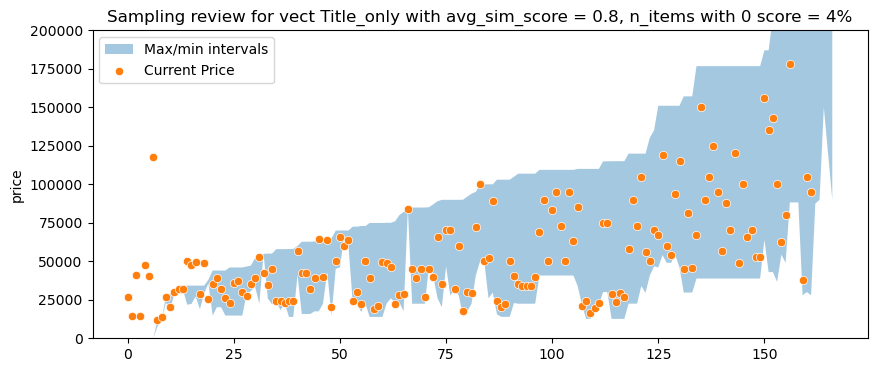

Market review for texts combination Title + cat:
{'vectors': 'Title + cat', 'sim_threshold': 0.75, '% with 0 score': 2, 'avg min_max range': 174141, 'avg_sim_score': 0.81, '% with min_max range': 91}


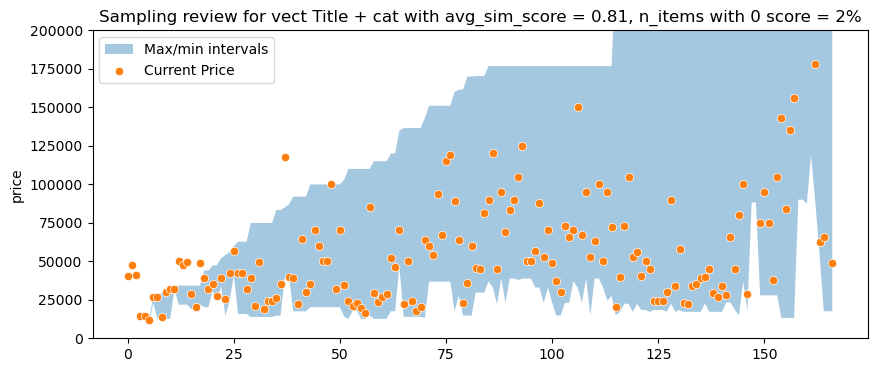

Market review for texts combination Title + full character:
{'vectors': 'Title + full character', 'sim_threshold': 0.75, '% with 0 score': 3, 'avg min_max range': 232934, 'avg_sim_score': 0.74, '% with min_max range': 86}


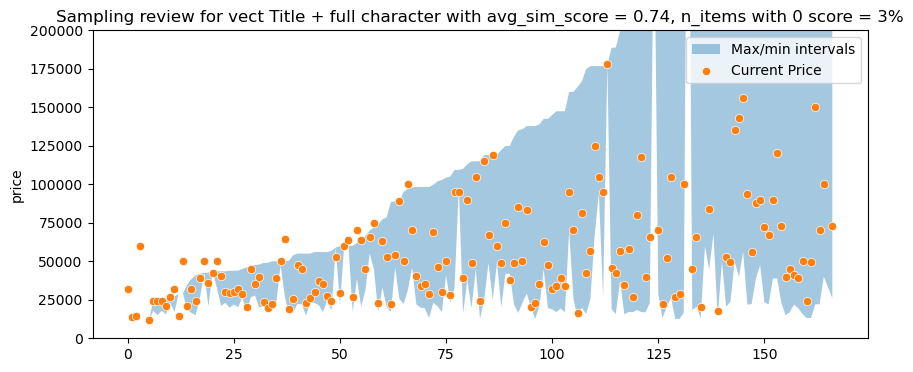

Market review for texts combination Title + short character:
{'vectors': 'Title + short character', 'sim_threshold': 0.75, '% with 0 score': 2, 'avg min_max range': 433688, 'avg_sim_score': 0.77, '% with min_max range': 95}


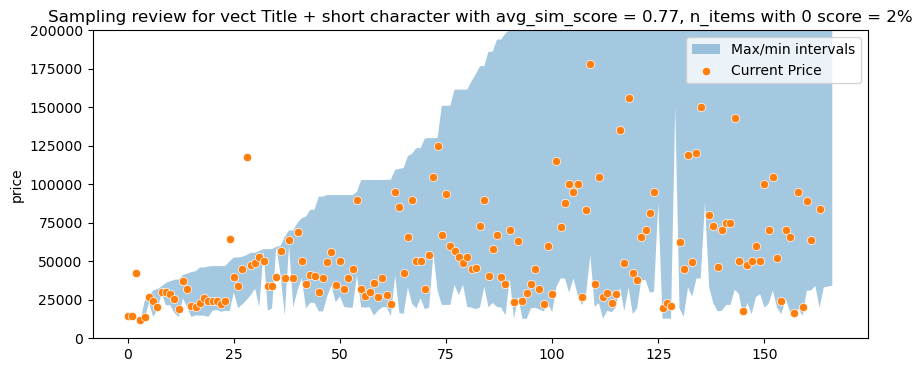

In [30]:
for ind, item  in enumerate(combo_names):
    print(f'Market review for texts combination {item}:')  
    market_review(vect_type = item,
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.75)

Market review for texts combination Title_only:
{'vectors': 'Title_only', 'sim_threshold': 0.79, '% with 0 score': 7, 'avg min_max range': 68160, 'avg_sim_score': 0.8, '% with min_max range': 79}


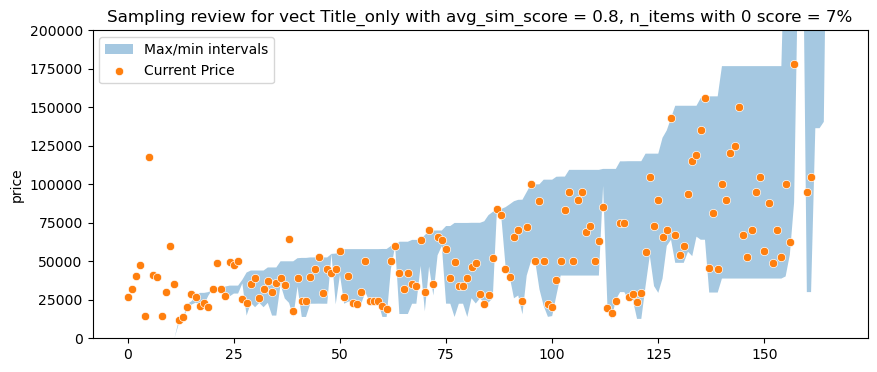

Market review for texts combination Title + cat:
{'vectors': 'Title + cat', 'sim_threshold': 0.79, '% with 0 score': 3, 'avg min_max range': 131333, 'avg_sim_score': 0.83, '% with min_max range': 88}


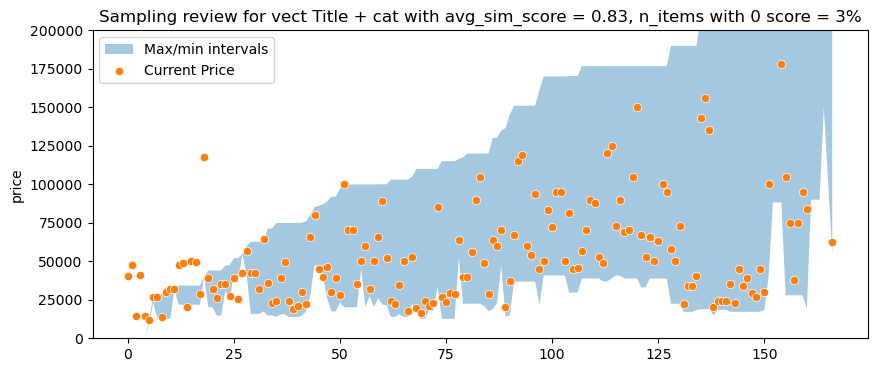

Market review for texts combination Title + full character:
{'vectors': 'Title + full character', 'sim_threshold': 0.79, '% with 0 score': 46, 'avg min_max range': 14188, 'avg_sim_score': 0.44, '% with min_max range': 33}


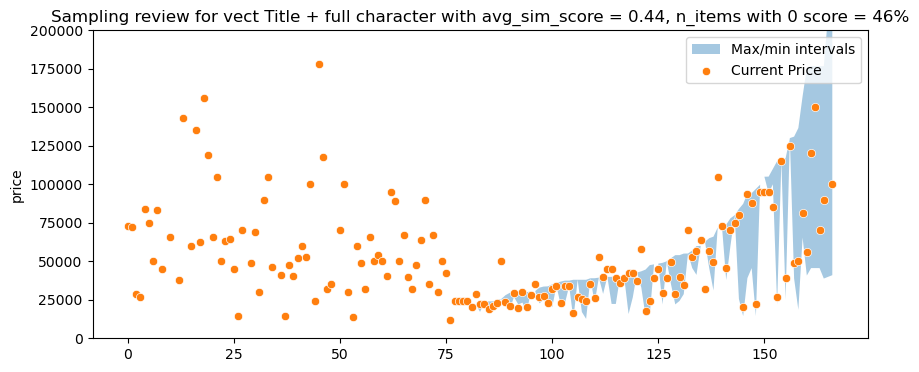

Market review for texts combination Title + short character:
{'vectors': 'Title + short character', 'sim_threshold': 0.79, '% with 0 score': 8, 'avg min_max range': 67773, 'avg_sim_score': 0.75, '% with min_max range': 82}


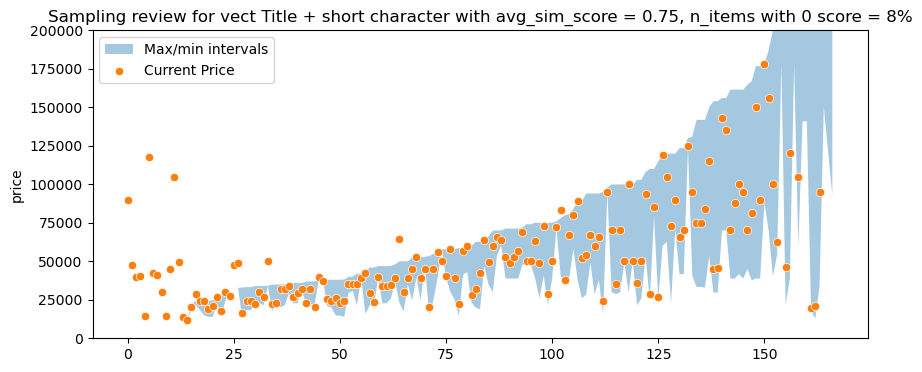

In [31]:
for ind, item  in enumerate(combo_names):
    print(f'Market review for texts combination {item}:')  
    market_review(vect_type = item,
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)

Market review for texts combination Title_only:
{'vectors': 'Title_only', 'sim_threshold': 0.8, '% with 0 score': 8, 'avg min_max range': 60959, 'avg_sim_score': 0.81, '% with min_max range': 78}


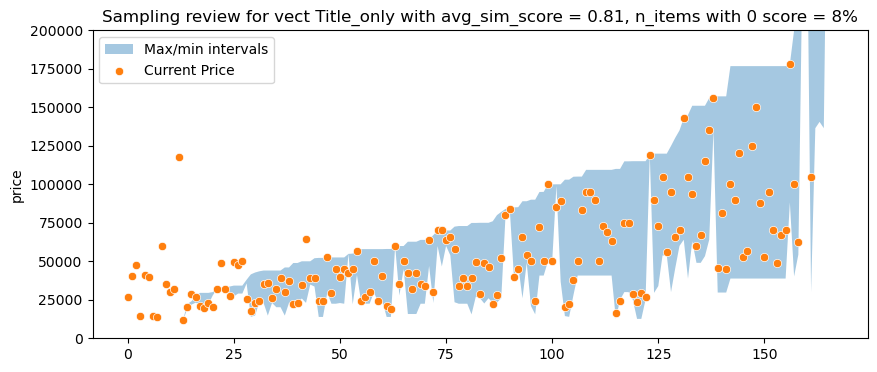

Market review for texts combination Title + cat:
{'vectors': 'Title + cat', 'sim_threshold': 0.8, '% with 0 score': 3, 'avg min_max range': 122772, 'avg_sim_score': 0.84, '% with min_max range': 87}


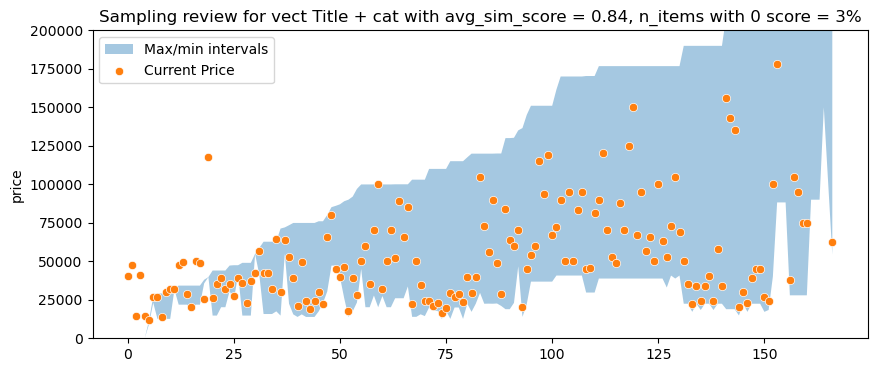

Market review for texts combination Title + full character:
{'vectors': 'Title + full character', 'sim_threshold': 0.8, '% with 0 score': 60, 'avg min_max range': 5753, 'avg_sim_score': 0.32, '% with min_max range': 20}


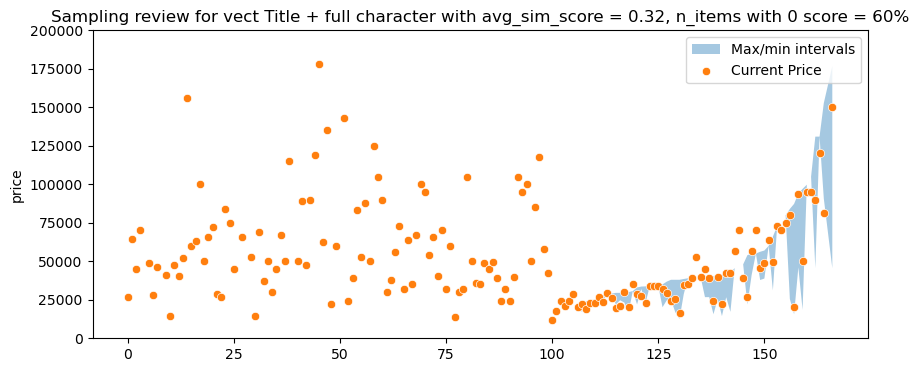

Market review for texts combination Title + short character:
{'vectors': 'Title + short character', 'sim_threshold': 0.8, '% with 0 score': 10, 'avg min_max range': 45374, 'avg_sim_score': 0.74, '% with min_max range': 76}


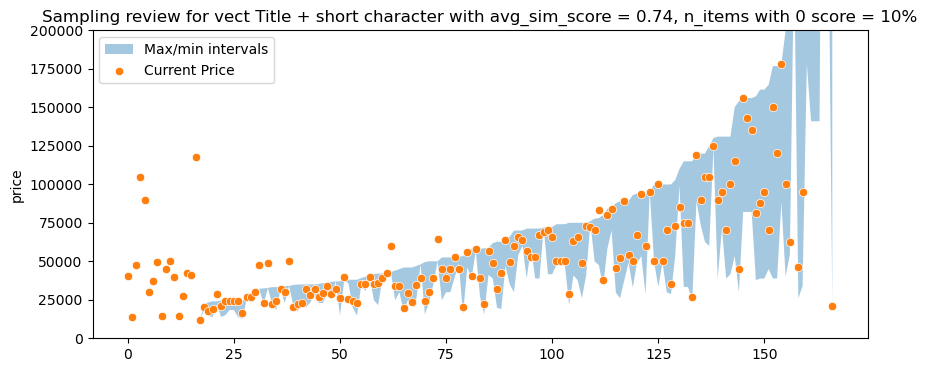

In [32]:
for ind, item  in enumerate(combo_names):
    print(f'Market review for texts combination {item}:')  
    market_review(vect_type = item,
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.8)

In [89]:
with open('eval.json',"r") as f:
    loaded = json.load(f)
res = pd.DataFrame(loaded)

res.sort_values(by = 'avg min_max range').style.highlight_min(color = 'lightgreen', subset = ['% with 0 score', 'avg min_max range'], axis = 0).\
                        highlight_max(color = 'red', subset = ['avg_sim_score', '% with min_max range'], axis = 0)

,vectors,sim_threshold,% with 0 score,avg min_max range,avg_sim_score,% with min_max range
10,Title + full character,0.800000,60,5753,0.320000,20
6,Title + full character,0.790000,46,14188,0.440000,33
11,Title + short character,0.800000,10,45374,0.740000,76
8,Title_only,0.800000,8,60959,0.810000,78
7,Title + short character,0.790000,8,67773,0.750000,82
4,Title_only,0.790000,7,68160,0.800000,79
13,Title_only,0.790000,7,68160,0.800000,79
0,Title_only,0.750000,4,89386,0.800000,84
9,Title + cat,0.800000,3,122772,0.840000,87
5,Title + cat,0.790000,3,131333,0.830000,88


In [51]:
eval_list = []
with open('eval2.json',"w") as f:
        json.dump(eval_list, f)

In [79]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor


def group_price_pred(model, vect_type, data, competitors, data_vect, competitors_vect, sim_threshhold):
        """data - dataframe with own products
        competitors - dataframe with competitors' products
        data_vect - data in vectorized form
        competitors_vect - competitors data in vectorized form
        sim_threshhold - min similarity score to be inlcuded in recommendation"""

        similar_items = []
        scores_total = []
        gr = data.copy()
        data_emb = sparse.csr_matrix(data_vect)
        competitors_emb = sparse.csr_matrix(competitors_vect)
        #print(f'Log: start to search for similar items with threshhold {sim_threshhold}...')

        for item in range(len(data)):
            similarity = cosine_similarity(data_emb[item], competitors_emb).flatten()
            ind = np.argwhere(similarity > sim_threshhold)
            if ind.shape[0] == 0:
                pass
            else:
                scores = similarity[similarity > sim_threshhold]
                scores_total.extend(scores)
                flat_list = [item for sublist in ind.tolist() for item in sublist]
                similar_items.extend(flat_list)
        group_ind = set(similar_items)

        group_avg_score = round(sum(scores_total)/len(scores_total),2)

        print(f'Total similar items for the group = {len(group_ind)}')

        if len(group_ind) <= len(data):
            print('Similar group is too small, prediction not possible!')
        else:
            X = competitors_emb[list(group_ind)]
            y = competitors['price'][list(group_ind)]
            X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
            #model = CatBoostRegressor(verbose=False)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            RMSE = round(np.sqrt(mean_squared_error(y_test, y_pred)),2)
            new_row = {'RMSE':round(np.sqrt(mean_squared_error(y_test, y_pred)),2),
                       'R2_score': round(r2_score(y_test, y_pred),4)}

            print(f'Log: training done, results: {new_row}')

            X_val = data_emb
            y_val = model.predict(X_val)
            gr['pred_price'] = y_val
            
            results = {'vectors': vect_type,
                       'sim_threshold': sim_threshhold,
                       'RMSE_valid':round(np.sqrt(mean_squared_error(y_test, y_pred)),2),
                       'R2_score_valid': round(r2_score(y_test, y_pred),4),
                       'RMSE_test': round(np.sqrt(mean_squared_error(gr['price'], gr['pred_price'])),2),
                       'R2_score_test': round(r2_score(gr['price'], gr['pred_price']),4)
                      }
                
                  

            if os.path.exists('eval2.json'):
                with open('eval2.json',"r") as f:
                    loaded = json.load(f)
                with open('eval2.json',"w") as f:
                    loaded.append(results)
                    json.dump(loaded, f)
            else:
                 with open('eval2.json',"w") as f:
                        json.dump(review_results, f)
            
            gr = gr.sort_values(by = 'price')

            plt.figure(figsize = [10,4])
            plt.fill_between(y1 = gr['pred_price'] - RMSE,
                                 y2 = gr['pred_price'] + RMSE,
                                x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                                alpha = 0.2,
                                label = 'Conf intervals')
            sns.scatterplot(x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                          y = gr['pred_price'], label = 'Prediction')
            sns.scatterplot(x = np.linspace(0,len(gr), num = len(gr)).astype(int),
                          y = gr['price'], label = 'Current Price')
            plt.legend(loc = 'best')
            plt.ylim(0,200000)
            plt.title(f'Price prediction based on similarity score, group_avg = {group_avg_score}, RMSE = {RMSE}')
        plt.show()
        return gr, round(np.sqrt(mean_squared_error(gr['price'], gr['pred_price'])),2)

Price prediction for texts combination Title_only:
Total similar items for the group = 1755
Log: training done, results: {'RMSE': 33669.21, 'R2_score': 0.8788}


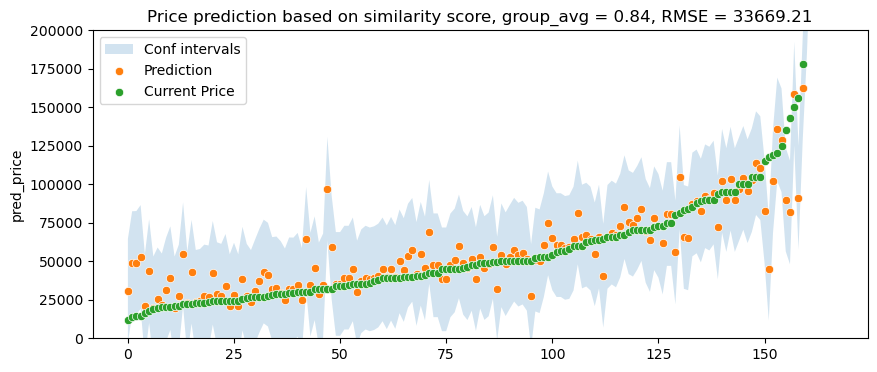

Price prediction for texts combination Title + cat:
Total similar items for the group = 2404
Log: training done, results: {'RMSE': 35238.7, 'R2_score': 0.8929}


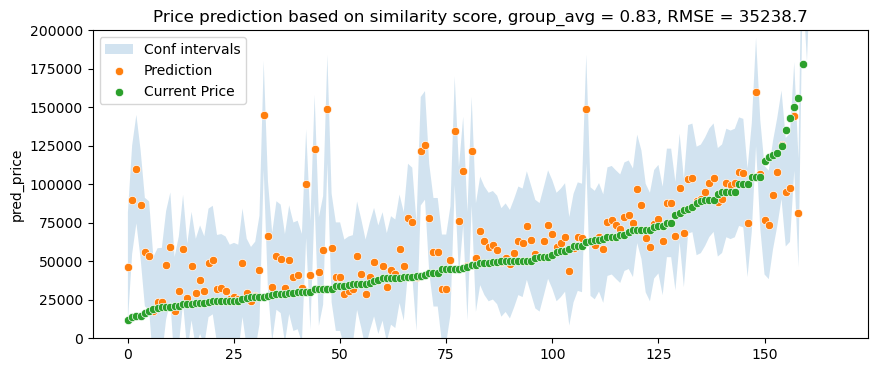

Price prediction for texts combination Title + full character:
Total similar items for the group = 1255
Log: training done, results: {'RMSE': 88233.38, 'R2_score': 0.4309}


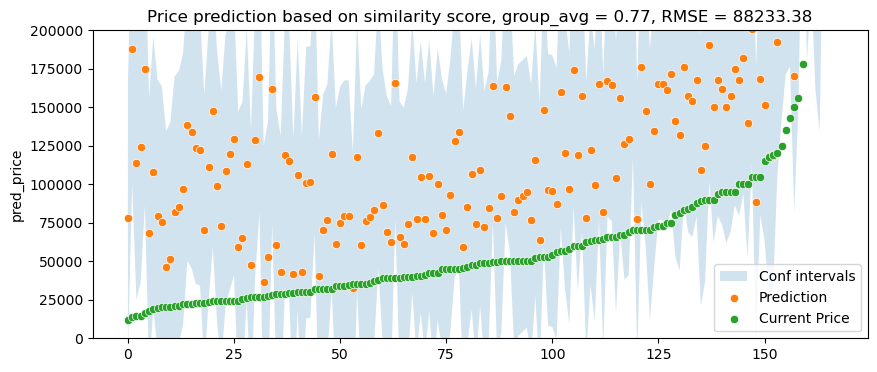

Price prediction for texts combination Title + short character:
Total similar items for the group = 1980
Log: training done, results: {'RMSE': 131339.76, 'R2_score': 0.6245}


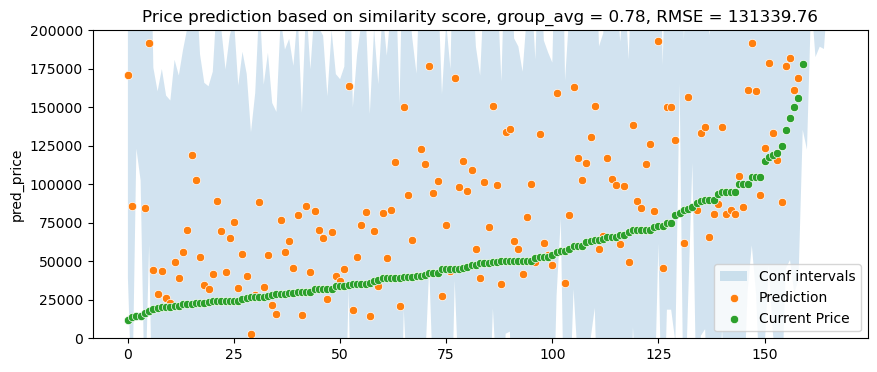

In [53]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(vect_type = item,
               model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.75)

Price prediction for texts combination Title_only:
Total similar items for the group = 1503
Log: training done, results: {'RMSE': 20046.92, 'R2_score': 0.9454}


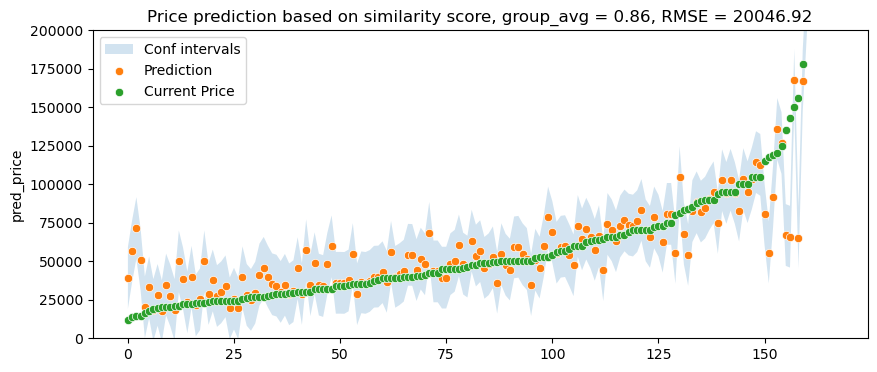

Price prediction for texts combination Title + cat:
Total similar items for the group = 2008
Log: training done, results: {'RMSE': 32772.95, 'R2_score': 0.8911}


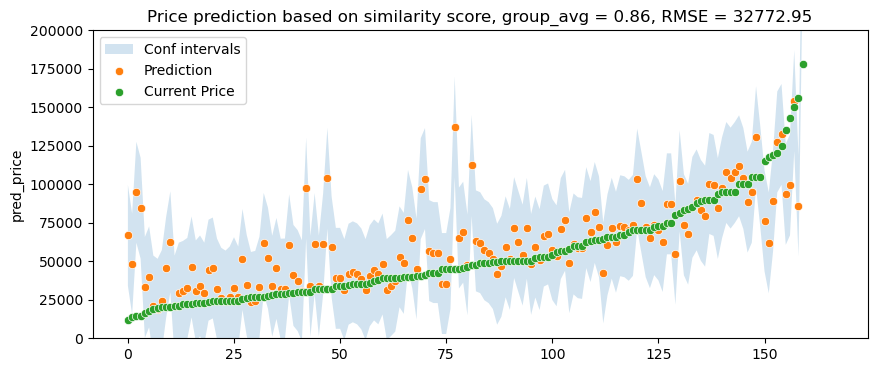

Price prediction for texts combination Title + full character:
Total similar items for the group = 225
Log: training done, results: {'RMSE': 21501.27, 'R2_score': 0.3284}


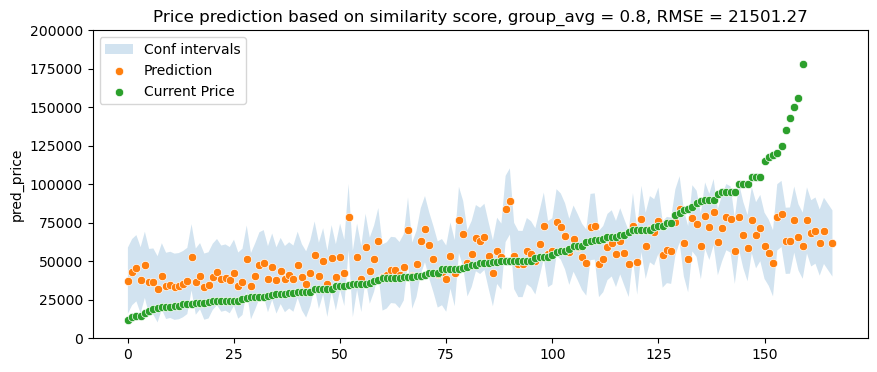

Price prediction for texts combination Title + short character:
Total similar items for the group = 854
Log: training done, results: {'RMSE': 63951.63, 'R2_score': 0.5553}


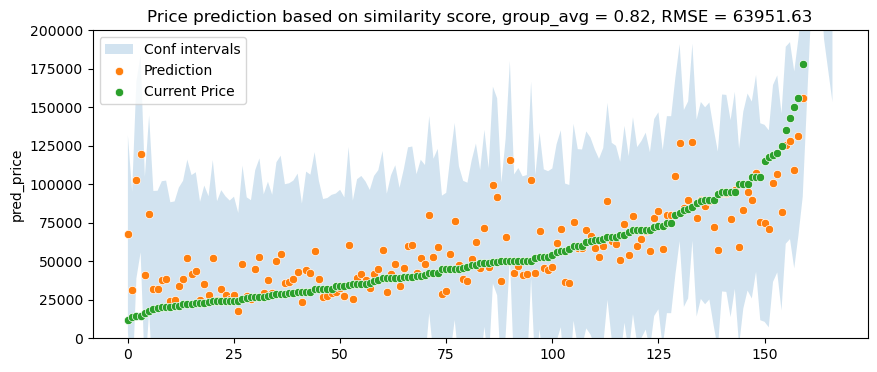

In [54]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(vect_type = item,
               model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.79)

Price prediction for texts combination Title_only:
Total similar items for the group = 1453
Log: training done, results: {'RMSE': 35898.57, 'R2_score': 0.8408}


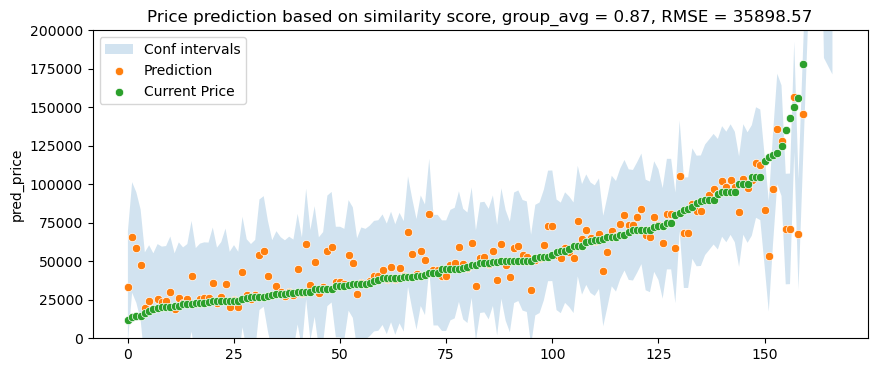

Price prediction for texts combination Title + cat:
Total similar items for the group = 1905
Log: training done, results: {'RMSE': 29397.44, 'R2_score': 0.9049}


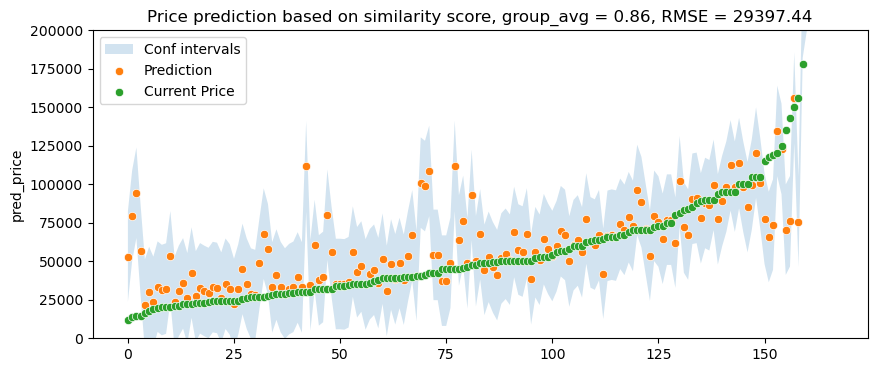

Price prediction for texts combination Title + full character:
Total similar items for the group = 137
Similar group is too small, prediction not possible!
Price prediction for texts combination Title + short character:
Total similar items for the group = 692
Log: training done, results: {'RMSE': 49031.84, 'R2_score': 0.7692}


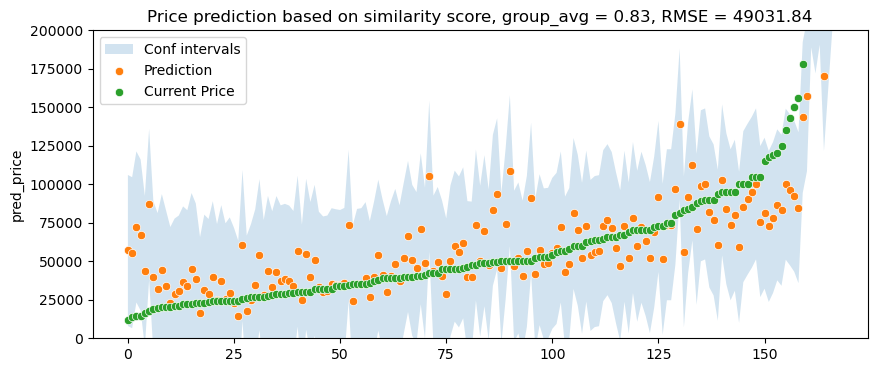

In [55]:
for ind, item  in enumerate(combo_names):
    print(f'Price prediction for texts combination {item}:')  
    group_price_pred(vect_type = item,
               model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[ind], 
               competitors_vect = competitors_vect_lst[ind],
               sim_threshhold = 0.8)

In [56]:
with open('eval2.json',"r") as f:
    loaded = json.load(f)
res2 = pd.DataFrame(loaded)
res2.sort_values(by = 'RMSE_test').style.highlight_min(color = 'lightgreen', subset = ['RMSE_valid', 'RMSE_test'], axis = 0).\
                        highlight_max(color = 'red', subset = ['R2_score_valid', 'R2_score_test'], axis = 0)

,vectors,sim_threshold,RMSE_valid,R2_score_valid,RMSE_test,R2_score_test
0,Title_only,0.750000,33669.210000,0.878800,32895.610000,0.797700
9,Title + cat,0.800000,29397.440000,0.904900,34177.700000,0.781600
5,Title + cat,0.790000,32772.950000,0.891100,34741.570000,0.774300
4,Title_only,0.790000,20046.920000,0.945400,36998.510000,0.744100
1,Title + cat,0.750000,35238.700000,0.892900,38804.920000,0.718500
7,Title + short character,0.790000,63951.630000,0.555300,40753.840000,0.689500
8,Title_only,0.800000,35898.570000,0.840800,41025.460000,0.685300
10,Title + short character,0.800000,49031.840000,0.769200,45275.620000,0.616700
3,Title + short character,0.750000,131339.760000,0.624500,64469.120000,0.222900
6,Title + full character,0.790000,21501.270000,0.328400,69458.350000,0.098000


In [57]:
res_total = res.merge(res2, on = ['vectors', 'sim_threshold'])
res_total.sort_values(by = 'RMSE_test').style.highlight_min(color = 'lightgreen', subset = ['RMSE_valid', 'RMSE_test','% with 0 score', 'avg min_max range'], axis = 0).\
                        highlight_max(color = 'red', subset = ['R2_score_valid', 'R2_score_test', 'avg_sim_score', '% with min_max range'], axis = 0)

,vectors,sim_threshold,% with 0 score,avg min_max range,avg_sim_score,% with min_max range,RMSE_valid,R2_score_valid,RMSE_test,R2_score_test
0,Title_only,0.750000,4,89386,0.800000,84,33669.210000,0.878800,32895.610000,0.797700
9,Title + cat,0.800000,3,122772,0.840000,87,29397.440000,0.904900,34177.700000,0.781600
5,Title + cat,0.790000,3,131333,0.830000,88,32772.950000,0.891100,34741.570000,0.774300
4,Title_only,0.790000,7,68160,0.800000,79,20046.920000,0.945400,36998.510000,0.744100
1,Title + cat,0.750000,2,174141,0.810000,91,35238.700000,0.892900,38804.920000,0.718500
7,Title + short character,0.790000,8,67773,0.750000,82,63951.630000,0.555300,40753.840000,0.689500
8,Title_only,0.800000,8,60959,0.810000,78,35898.570000,0.840800,41025.460000,0.685300
10,Title + short character,0.800000,10,45374,0.740000,76,49031.840000,0.769200,45275.620000,0.616700
3,Title + short character,0.750000,2,433688,0.770000,95,131339.760000,0.624500,64469.120000,0.222900
6,Title + full character,0.790000,46,14188,0.440000,33,21501.270000,0.328400,69458.350000,0.098000


{'vectors': 'Title_only', 'sim_threshold': 0.79, '% with 0 score': 7, 'avg min_max range': 68160, 'avg_sim_score': 0.8, '% with min_max range': 79}


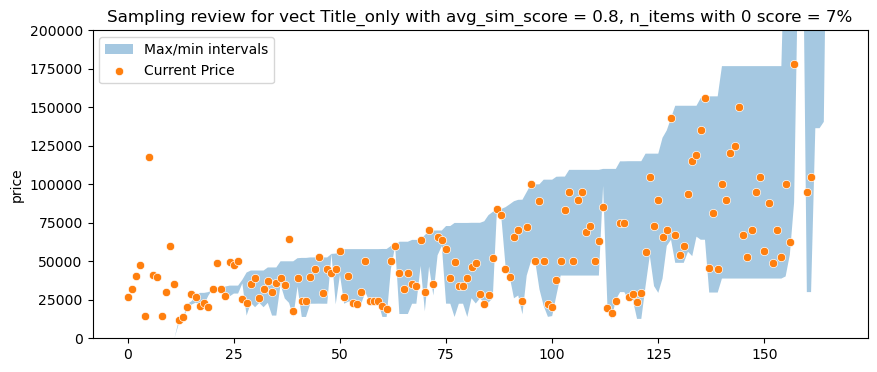

In [60]:
best1 = market_review(vect_type = 'Title_only',
           data = df1, 
           competitors = df, 
           data_vect = data_vect_lst[0], 
           competitors_vect = competitors_vect_lst[0],
           sim_threshhold = 0.79)

In [62]:
best1

,title,article,price,cat_1,cat_2,cat_3,url,description,caracteristics,source,...,len,wid,dist,calories,capacity,display,avg_sim_score,price_max,price_min,in_range
0,Беговая дорожка Planta TM-400,400127733,26999,Тренажеры,Беговые дорожки,Planta,https://img.mvideo.ru/Pdb/400127733b.jpg,Беговая дорожка Planta TM-400 подходит для по...,Гарантия 3 года Страна Китай Длина полотна 110...,www.mvideo.ru,...,Длина полотна 110 см,Ширина полотна 40 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 1.25,Цифровой дисплей Да,0.00,0,0,0
2,Беговая дорожка Planta TM-300,4208420,31999,Тренажеры,Беговые дорожки,Planta,https://img.mvideo.ru/Pdb/4208420b.jpg,Тренировочная беговая дорожка Planta TM-300 г...,Гарантия 1 месяц Страна Китай Длина полотна 11...,www.mvideo.ru,...,Длина полотна 110 см,Ширина полотна 40 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,0.00,0,0,0
87,Беговая дорожка ONLITOP 4314756,400124140,40690,Тренажеры,Беговые дорожки,ONLITOP,https://img.mvideo.ru/Pdb/400124140b.jpg,Беговая дорожка Onlitop 4314756 способна выде...,Гарантия 1 год Страна Китай Длина полотна 150....,www.mvideo.ru,...,Длина полотна 150.5 см,Ширина полотна 73.8 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,0.00,0,0,0
88,Беговая дорожка ONLITOP 4314759,400124141,47290,Тренажеры,Беговые дорожки,ONLITOP,https://img.mvideo.ru/Pdb/400124141b.jpg,Беговая дорожка Onlitop 4314759 способна выде...,Гарантия 6 месяцев Страна Китай Длина полотна ...,www.mvideo.ru,...,Длина полотна 150.3 см,Ширина полотна 81 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,0.00,0,0,0
89,Беговая дорожка ONLYTOP 537821,400124137,14690,Тренажеры,Беговые дорожки,ONLYTOP,https://img.mvideo.ru/Pdb/400124137b.jpg,Беговая дорожка Onlytop 537821 походит для де...,Гарантия 3 месяца Страна Китай Длина полотна 6...,www.mvideo.ru,...,Длина полотна 68 см,Ширина полотна 52 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,0.00,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Беговая дорожка CardioPower S500,400077266,104990,Тренажеры,Беговые дорожки,CardioPower,https://img.mvideo.ru/Big/400077266bb.jpg,Беговая дорожка CardioPower S500 позволяет на...,Гарантия 2 года Страна Китай Обратите внимание...,www.mvideo.ru,...,Длина полотна 140 см,Ширина полотна 46 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 3,Цифровой дисплей Да,0.86,489900,29990,1
151,Беговая дорожка Bronze Gym T815M,400170453,215990,Тренажеры,Беговые дорожки,Bronze Gym,https://img.mvideo.ru/Big/400170453bb.jpg,,Гарантия 3 года Страна Китай Обратите внимание...,www.mvideo.ru,...,Длина полотна 150 см,Ширина полотна 56 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 4,Цифровой дисплей Да,0.86,512990,136423,1
99,Беговая дорожка Bronze Gym T960M_TFT,400084242,512990,Тренажеры,Беговые дорожки,Bronze Gym,https://img.mvideo.ru/Big/400084242bb.jpg,Беговая дорожка Bronze Gym T960M_TFT оснащена...,Гарантия 3 года Страна Китай Обратите внимание...,www.mvideo.ru,...,Длина полотна 155 см,Ширина полотна 60 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 7.2,Цифровой дисплей Да,0.85,512990,136423,1
67,Беговая дорожка Bronze Gym T930M,400075172,347990,Тренажеры,Беговые дорожки,Bronze Gym,https://img.mvideo.ru/Big/400075172bb.jpg,,Гарантия 3 года Страна Китай Обратите внимание...,www.mvideo.ru,...,Длина полотна 156 см,Ширина полотна 58 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 7,Цифровой дисплей Да,0.85,512990,140540,1


Total similar items for the group = 1503
Log: training done, results: {'RMSE': 20046.92, 'R2_score': 0.9454}


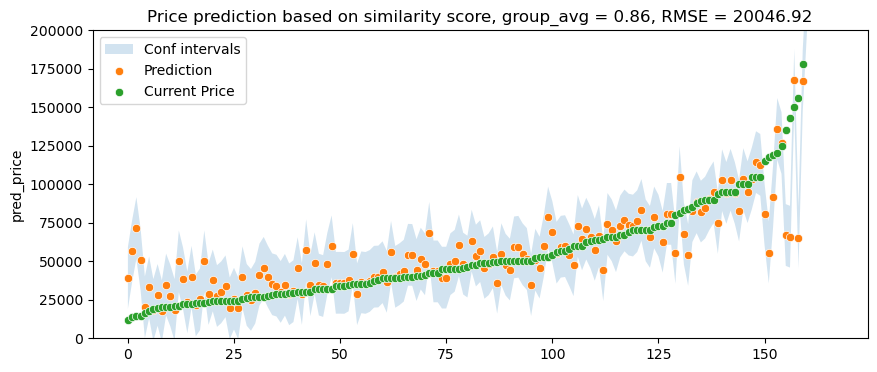

In [82]:
best2, RMSE = group_price_pred(vect_type = 'Title_only',
               model = CatBoostRegressor(verbose=False),
               data = df1, 
               competitors = df, 
               data_vect = data_vect_lst[0], 
               competitors_vect = competitors_vect_lst[0],
               sim_threshhold = 0.79)

In [83]:
fin = best1.merge(best2, on = 'article')
fin

,title_x,article,price_x,cat_1_x,cat_2_x,cat_3_x,url_x,description_x,caracteristics_x,source_x,...,date_y,weight_y,speed_y,len_y,wid_y,dist_y,calories_y,capacity_y,display_y,pred_price
0,Беговая дорожка Planta TM-400,400127733,26999,Тренажеры,Беговые дорожки,Planta,https://img.mvideo.ru/Pdb/400127733b.jpg,Беговая дорожка Planta TM-400 подходит для по...,Гарантия 3 года Страна Китай Длина полотна 110...,www.mvideo.ru,...,2023-08-16,Максимальный вес пользователя 110 кг,Максимальная скорость 12 км/ч,Длина полотна 110 см,Ширина полотна 40 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 1.25,Цифровой дисплей Да,45775.388266
1,Беговая дорожка Planta TM-300,4208420,31999,Тренажеры,Беговые дорожки,Planta,https://img.mvideo.ru/Pdb/4208420b.jpg,Тренировочная беговая дорожка Planta TM-300 г...,Гарантия 1 месяц Страна Китай Длина полотна 11...,www.mvideo.ru,...,2023-08-16,Максимальный вес пользователя 100 кг,Максимальная скорость 12 км/ч,Длина полотна 110 см,Ширина полотна 40 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,48526.539521
2,Беговая дорожка ONLITOP 4314756,400124140,40690,Тренажеры,Беговые дорожки,ONLITOP,https://img.mvideo.ru/Pdb/400124140b.jpg,Беговая дорожка Onlitop 4314756 способна выде...,Гарантия 1 год Страна Китай Длина полотна 150....,www.mvideo.ru,...,2023-08-16,см Максимальный вес пользователя 130 кг,Максимальная скорость 12 км/ч,Длина полотна 150.5 см,Ширина полотна 73.8 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,51746.259518
3,Беговая дорожка ONLITOP 4314759,400124141,47290,Тренажеры,Беговые дорожки,ONLITOP,https://img.mvideo.ru/Pdb/400124141b.jpg,Беговая дорожка Onlitop 4314759 способна выде...,Гарантия 6 месяцев Страна Китай Длина полотна ...,www.mvideo.ru,...,2023-08-16,Максимальный вес пользователя 110 кг,Максимальная скорость 12 км/ч,Длина полотна 150.3 см,Ширина полотна 81 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,63403.919440
4,Беговая дорожка ONLYTOP 537821,400124137,14690,Тренажеры,Беговые дорожки,ONLYTOP,https://img.mvideo.ru/Pdb/400124137b.jpg,Беговая дорожка Onlytop 537821 походит для де...,Гарантия 3 месяца Страна Китай Длина полотна 6...,www.mvideo.ru,...,2023-08-16,Максимальный вес пользователя 60 кг,,Длина полотна 68 см,Ширина полотна 52 см,Индикация дистанции Да,Индикация расхода калорий Да,,Цифровой дисплей Да,50996.182543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Беговая дорожка CardioPower S500,400077266,104990,Тренажеры,Беговые дорожки,CardioPower,https://img.mvideo.ru/Big/400077266bb.jpg,Беговая дорожка CardioPower S500 позволяет на...,Гарантия 2 года Страна Китай Обратите внимание...,www.mvideo.ru,...,2023-08-16,см Максимальный вес пользователя 145 кг,Максимальная скорость 18 км/ч,Длина полотна 140 см,Ширина полотна 46 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 3,Цифровой дисплей Да,114390.523798
162,Беговая дорожка Bronze Gym T815M,400170453,215990,Тренажеры,Беговые дорожки,Bronze Gym,https://img.mvideo.ru/Big/400170453bb.jpg,,Гарантия 3 года Страна Китай Обратите внимание...,www.mvideo.ru,...,2023-08-16,см Максимальный вес пользователя 160 кг,Максимальная скорость 20 км/ч,Длина полотна 150 см,Ширина полотна 56 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 4,Цифровой дисплей Да,219101.081541
163,Беговая дорожка Bronze Gym T960M_TFT,400084242,512990,Тренажеры,Беговые дорожки,Bronze Gym,https://img.mvideo.ru/Big/400084242bb.jpg,Беговая дорожка Bronze Gym T960M_TFT оснащена...,Гарантия 3 года Страна Китай Обратите внимание...,www.mvideo.ru,...,2023-08-16,см Максимальный вес пользователя 180 кг,см Максимальная скорость 22 км/ч,Длина полотна 155 см,Ширина полотна 60 см,Индикация дистанции Да,Индикация расхода калорий Да,Мощность двигателя (л.с.) 7.2,Цифровой дисплей Да,234641.293736
164,Беговая дорожка Bronze Gym T930M,400075172,347990,Тренажеры,Бег

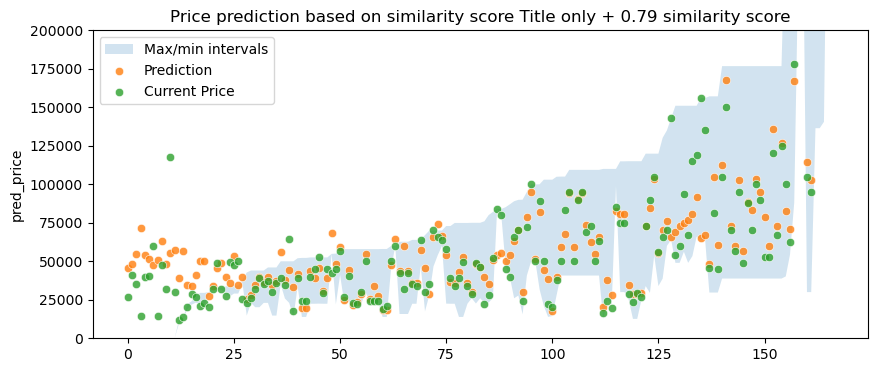

In [90]:
plt.figure(figsize = [10,4])
fin = fin.sort_values(by = 'price_max')
plt.fill_between(y1 = fin['price_max'],
                 y2 = fin['price_min'],
                x = np.linspace(0,len(fin), num = len(fin)).astype(int),
                alpha = 0.2,
                label = 'Max/min intervals')

sns.scatterplot(x = np.linspace(0,len(fin), num = len(fin)).astype(int),
              y = fin['pred_price'], label = 'Prediction', alpha = 0.8)
sns.scatterplot(x = np.linspace(0,len(fin), num = len(fin)).astype(int),
              y = fin['price_x'], label = 'Current Price', alpha = 0.8)

plt.legend(loc = 'best')
plt.ylim(0,200000)
plt.title(f'Price prediction based on similarity score Title only + 0.79 similarity score')
plt.show()

In [86]:
fin['price_x'].mean()

65890.078313253